### Projeto DataScience: prevendo a existência e quantidade de Leads em anúncios de um marketplace veícular

### Visão Geral do projeto

Iremos dividir este relatório em três grandes objetivos: 

1. Realizar análise exploratória para, além de conhecer os dados, retirar insights dos dados: verificar como os leads variam de acordo com algumas features do dataset.
2. Desenvolver modelos de classificação que possam prever se um determinado anúncio terá Leads ou não.
3. Construir modelos regressivos que também possam prever quantos leads um determinado assunto irá receber.

### Endereçando o problema:

1. Para o primeiro ponto acima iremos realizar uma análise exploratória (EDA) para identificar que características dos anúncios estão mais associadas com as mudanças nas quantidades de leads. Notadamente iremos verificar a quantidade de leads por marca e modelo do veículo anunciado, a sua cidade, o ano do modelo e algumas outras características pertinentes;

2. Para determinar se um anúncio terá leads ou não, iremos propor a construção de 4 modelos preditivo do tipo "two-class" (ou binário): RandomForest, Regressão Logística, Knn e Naive Bayes. Para alcançar este objetivo, precisaremos de uma feature adequada a ser usada como label e, portanto, iremos criar uma nova coluna no dataset chamada `has_lead`. Esta coluna receberá valor `1` caso o anúncio tenha recebido algum lead e `0` caso tenha recebido nenhum. Ao final, iremos avaliar a melhor performance entre os modelos pelas métricas derivadas da matriz de confusão: Acurracy, AUC score, F1 Score e AUPRC (Area Under the Precision-Recall Curve).

3. Por fim, com o objetivo de identificar quantos leads um determinado anúncio pode receber, iremos propor a construção de quatro modelos de Regressão: Linear, MLP Regressor, RandomForest e ElasticNet. O objetivo será criar uma função que possa prever a quantidade de leads com base nas características do anúncio. Aquele modelo com as melhores métricas de desempenho (MAE, MSE, RMSE) será o escolhido. 

4. Para dar mais robustez aos modelos, usaremos estratégias de Feature Engineering e Feature Selection visando criar features com melhor poder preditivo que as originais, além de selecionar as melhores para tal tarefa. Os modelos criados serão rodados por métodos de validação cruzada (estratificada e simples) pelo menos 5 vezes em cada folder. Cada modelo aqui criado foi computado 20 vezes (5 execuções x 4 Folds) e as médias das respectivas métricas e seu desvio-padrão serão levadas em consideração para avaliar sua consistência entre os resultados colhidos.

### Sobre o Dataset:

- Cada linha representa um anúncio de um determinado veículo e suas características em um markeplace automotivo.

## Tratamento dos Dados

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando a Base de Dados
dados = pd.read_csv('dados_leads.csv')
dados.head()

,Unnamed: 0,cod_anuncio,cod_cliente,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone*,cod_marca_veiculo,cod_modelo_veiculo,...,abs,desembtras,travaeletr,vidroseletr,rodasliga,sensorchuva,sensorestacion,uf,cidade,has_leads
0,1,6,1770,1,3,1,0,4,2,704,...,S,N,S,S,N,N,N,SP,Osasco,1
1,2,8,709,1,3,4,0,11,30,1071,...,S,S,S,S,S,N,N,SP,SÃ£o Paulo,1
2,3,13,9708,1,2,12,0,14,10,2028,...,N,N,S,S,S,N,N,SP,SÃ£o Paulo,1
3,4,15,1363,1,2,8,0,11,12,805,...,S,S,S,S,S,N,N,SP,SÃ£o Paulo,1
4,5,18,1880,2,3,0,0,4,2,1042,...,N,S,S,S,S,N,N,RS,Porto Alegre,0


In [3]:
# Verificando estrutura do dataset
estrutura_original = dados.shape
print(estrutura_original)

(48349, 45)


In [4]:
# Features disponíveis
dados.columns

Index(['Unnamed: 0', 'cod_anuncio', 'cod_cliente', 'cod_tipo_pessoa',
       'prioridade', 'leads', 'views', 'cliques_telefone*',
       'cod_marca_veiculo', 'cod_modelo_veiculo', 'cod_versao_veiculo',
       'ano_modelo', 'cep_2dig', 'uf_cidade', 'vlr_anuncio', 'qtd_fotos',
       'km_veiculo', 'vlr_mercado', 'flg_unico_dono', 'flg_licenciado',
       'flg_ipva_pago', 'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_garantia_fabrica',
       'flg_blindado', 'flg_aceita_troca', 'flg_adaptado_pcd', 'combustivel',
       'cambio', 'portas', 'alarme', 'airbag', 'arquente', 'bancocouro',
       'arcondic', 'abs', 'desembtras', 'travaeletr', 'vidroseletr',
       'rodasliga', 'sensorchuva', 'sensorestacion', 'uf', 'cidade',
       'has_leads'],
      dtype='object')

In [5]:
# Verificando tipagem dos dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48349 entries, 0 to 48348
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         48349 non-null  int64  
 1   cod_anuncio                        48349 non-null  int64  
 2   cod_cliente                        48349 non-null  int64  
 3   cod_tipo_pessoa                    48349 non-null  int64  
 4   prioridade                         48349 non-null  int64  
 5   leads                              48349 non-null  int64  
 6   views                              48349 non-null  int64  
 7   cliques_telefone*                  48349 non-null  int64  
 8   cod_marca_veiculo                  48349 non-null  int64  
 9   cod_modelo_veiculo                 48349 non-null  int64  
 10  cod_versao_veiculo                 48349 non-null  int64  
 11  ano_modelo                         48349 non-null  int

In [6]:
# Missing values
dados.isnull().sum()

Unnamed: 0                             0
cod_anuncio                            0
cod_cliente                            0
cod_tipo_pessoa                        0
prioridade                             0
leads                                  0
views                                  0
cliques_telefone*                      0
cod_marca_veiculo                      0
cod_modelo_veiculo                     0
cod_versao_veiculo                     0
ano_modelo                             0
cep_2dig                               0
uf_cidade                              0
vlr_anuncio                            0
qtd_fotos                              0
km_veiculo                             0
vlr_mercado                            0
flg_unico_dono                         0
flg_licenciado                         0
flg_ipva_pago                        311
flg_todas_revisoes_concessionaria    311
flg_todas_revisoes_agenda_veiculo      0
flg_garantia_fabrica                 311
flg_blindado    

Ponderações: 
1. As colunas `flg_todas_revisoes_concessionaria`, `flg_ipva_pago`, `flg_garantia_fabrica`, `flg_adaptado_pcd` e demais são variáveis categóricas (binárias) e devem ser transformadas. Iremos tratá-las de acordo para evitar problemas com a contagem de nulos.

2. A coluna `vlr_mercado`  possui um número considerável de valores ausentes em relação ao total de observações no dataset.

3. Para não perdemos estas informações, iremos substituir estes valores pela média ou pela mediana, e para tal, precisamos identificar a existência de outliers. Caso sim, optaremos por substituir os NA's pela mediana.

In [7]:
colunas_tratamento = ['flg_todas_revisoes_concessionaria','flg_ipva_pago','flg_garantia_fabrica','flg_adaptado_pcd','airbag',\
'combustivel', 'cambio', 'portas','alarme','arquente','bancocouro','arcondic','abs','desembtras','travaeletr','vidroseletr','rodasliga','sensorchuva','sensorestacion'] # criando filtro
dados[colunas_tratamento] = dados[colunas_tratamento].astype(str) # aplicando transformação
dados[colunas_tratamento].isnull().sum() # verificando NA's

flg_todas_revisoes_concessionaria    0
flg_ipva_pago                        0
flg_garantia_fabrica                 0
flg_adaptado_pcd                     0
airbag                               0
combustivel                          0
cambio                               0
portas                               0
alarme                               0
arquente                             0
bancocouro                           0
arcondic                             0
abs                                  0
desembtras                           0
travaeletr                           0
vidroseletr                          0
rodasliga                            0
sensorchuva                          0
sensorestacion                       0
dtype: int64

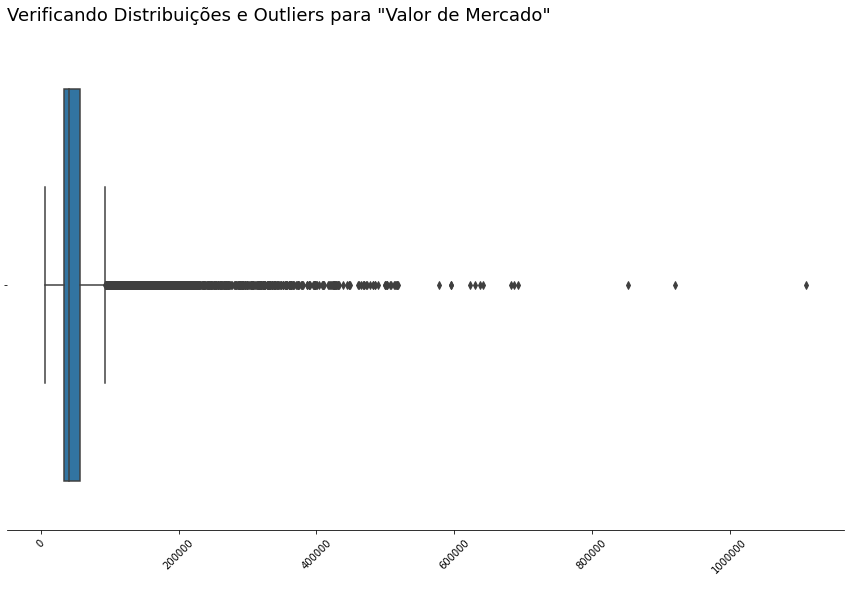

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando boxplot para verificar outliers da feature 'vlr_mercado'
boxplot_vlr_mercado = sns.boxplot('vlr_mercado', data=dados)
boxplot_vlr_mercado.figure.set_size_inches(15,9)
plt.xlabel(' ')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Verificando Distribuições e Outliers para "Valor de Mercado"', fontsize = 18, loc='left', pad =20)
sns.despine (left = True) 

In [9]:
# Média, Mediana, Desvio padrão e Coeficiente de Variação para 'vlr_mercado'
vlr_mercado_media = dados['vlr_mercado'].mean()
vlr_mercado_mediana = dados['vlr_mercado'].median()
vlr_mercado_desvPad = dados['vlr_mercado'].std()
print(f'O valor de mercado médio dos anúncios é {vlr_mercado_media:.2f}R$')
print(f'O valor de mercado mediano dos anúncios é {vlr_mercado_mediana:.2f}R$')
print(f'O valor de mercado possui desvio padrão de {vlr_mercado_desvPad:.2f}R$')
print(f'O coeficiente de variação é:',round((vlr_mercado_desvPad/vlr_mercado_media)*100,2),'%')


O valor de mercado médio dos anúncios é 51308.07R$
O valor de mercado mediano dos anúncios é 40668.75R$
O valor de mercado possui desvio padrão de 39151.51R$
O coeficiente de variação é: 76.31 %


Pelo gráfico e os valores acima, possuimos alguns outliers. É possível verificar diferenças significativas entre a média e mediana, e o desvio padrão também é alto quando comparado com a média. Portanto, iremos substituir os valores ausentes da coluna `vlr_mercado` pela Mediana.

In [10]:
dados['vlr_mercado'] = dados['vlr_mercado'].fillna(vlr_mercado_mediana)

dados['vlr_mercado'].isnull().sum() # verificando resultado

0

In [11]:
# Verificando NA's após tratamentos
dados.isnull().sum()

Unnamed: 0                           0
cod_anuncio                          0
cod_cliente                          0
cod_tipo_pessoa                      0
prioridade                           0
leads                                0
views                                0
cliques_telefone*                    0
cod_marca_veiculo                    0
cod_modelo_veiculo                   0
cod_versao_veiculo                   0
ano_modelo                           0
cep_2dig                             0
uf_cidade                            0
vlr_anuncio                          0
qtd_fotos                            0
km_veiculo                           0
vlr_mercado                          0
flg_unico_dono                       0
flg_licenciado                       0
flg_ipva_pago                        0
flg_todas_revisoes_concessionaria    0
flg_todas_revisoes_agenda_veiculo    0
flg_garantia_fabrica                 0
flg_blindado                         0
flg_aceita_troca         

In [12]:
# Retirando valor NaN de colunas categóricas
dados.query('abs == "nan"')
dados.drop(0, inplace=True)

In [13]:
# Por fim, excluiremos quaisquer possíveis linhas onde todas suas features apresentem valores NA
dados.dropna(how='all',inplace=True)

Para a coluna `uf_cidade` aplicaremos uma separação de strings, criando uma coluna apenas com os Estados e outra apenas com as cidades

In [14]:
dados[['uf', 'cidade']] = dados['uf_cidade'].str.split('_', expand=True)

In [15]:
# Após tratamento, preservamos a quantidade de observações originais
dados.shape

(48348, 45)

### Análise descritiva das features quantitativas


In [16]:
# Retirando notação científica da apresentação dos dados
pd.set_option('float_format', '{:.3f}'.format)

In [17]:
# Sumário

colunas_describe = ['leads','views','vlr_anuncio','vlr_mercado', 'km_veiculo', 'ano_modelo', 'cliques_telefone*'] # criando filtro p/ features
dados[colunas_describe].describe()

,leads,views,vlr_anuncio,vlr_mercado,km_veiculo,ano_modelo,cliques_telefone*
count,48348.000,48348.000,48348.000,48348.000,48348.000,48348.000,48348.000
mean,4.431,446.829,109734.109,51308.287,63222.248,2013.217,7.480
std,11.992,1107.691,2875753.008,39151.885,52142.320,4.743,11.477
min,0.000,0.000,3500.000,6292.844,0.000,1951.000,0.000
25%,1.000,76.000,30800.000,33042.439,29000.000,2011.000,2.000
50%,1.000,196.000,41490.000,40668.754,57000.000,2014.000,4.000
75%,4.000,452.000,64900.000,57328.405,89000.000,2016.000,9.000
max,364.000,93608.000,405000000.000,1111215.639,990000.000,2019.000,457.000


In [18]:
# Comparado medianas entre valor anunciado e valor de mercado
anuncio_mediana = dados['vlr_anuncio'].median()
mercado_mediana = dados['vlr_mercado'].median()
print(f'A mediana do valor dos anúncios é R${anuncio_mediana:.2f}, enquanto que a mediana dos valores praticados no mercado é R${mercado_mediana:.2f}')

A mediana do valor dos anúncios é R$41490.00, enquanto que a mediana dos valores praticados no mercado é R$40668.75


In [19]:
# Verificando características dos anúncios com maiores leads
max_leads = dados.query('leads == 364')
max_leads[colunas_describe+['ano_modelo','uf','combustivel','arcondic','travaeletr','vidroseletr','airbag']]

,leads,views,vlr_anuncio,vlr_mercado,km_veiculo,ano_modelo,cliques_telefone*,ano_modelo,uf,combustivel,arcondic,travaeletr,vidroseletr,airbag
8438,364,48,81000.000,95222.530,20000,2017,332,2017,SP,gasolina e alcool,S,S,S,S
26021,364,220,12900.000,12821.359,88888,2004,159,2004,RJ,gasolina e alcool,S,S,S,N


In [20]:
# Verificando anúncios com vlr_anuncio zerado
min_leads = dados.query('vlr_anuncio == 0')
min_leads[colunas_describe+['ano_modelo','uf','combustivel','arcondic','travaeletr','vidroseletr','airbag']]

,leads,views,vlr_anuncio,vlr_mercado,km_veiculo,ano_modelo,cliques_telefone*,ano_modelo,uf,combustivel,arcondic,travaeletr,vidroseletr,airbag


In [21]:
# Retirando registro
dados.drop(44509, inplace=True)

In [22]:
# Verificando anúncio com ano_modelo negativo
dados.query('ano_modelo < 0')

,Unnamed: 0,cod_anuncio,cod_cliente,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone*,cod_marca_veiculo,cod_modelo_veiculo,...,abs,desembtras,travaeletr,vidroseletr,rodasliga,sensorchuva,sensorestacion,uf,cidade,has_leads


In [23]:
# Retirando registros incompativeis
dados = dados.query('ano_modelo > 0')

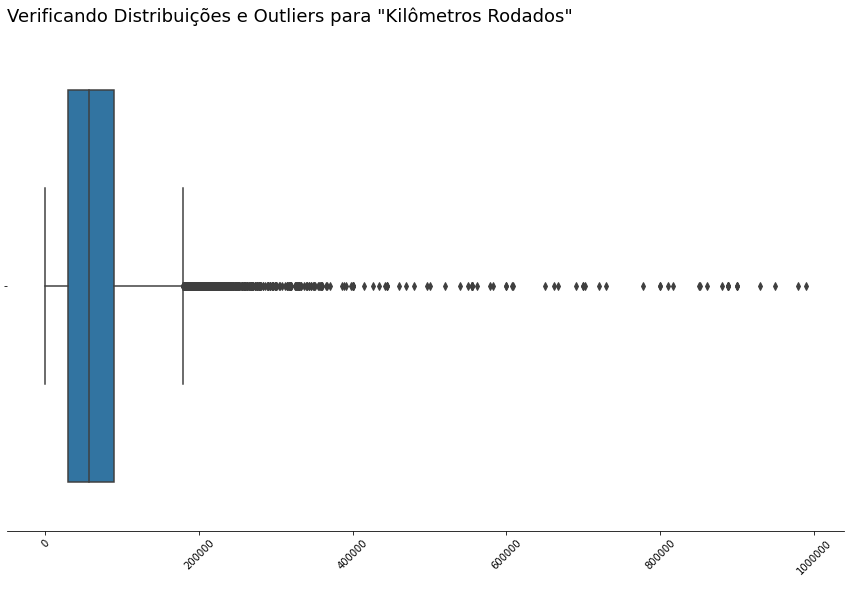

In [24]:
# verificando ouliers e valores irreais de kilometragem
box_km = sns.boxplot('km_veiculo', data=dados)
box_km.figure.set_size_inches(15,9)
plt.xlabel(' ')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Verificando Distribuições e Outliers para "Kilômetros Rodados"', fontsize = 18, loc='left', pad =20)
sns.despine (left = True) 

O dataset persite com valores muito discrepantes em relação aos outliers. Entendendo que não há uma regra de bolso para os problemas de outliers, iremos preservar o máximo de informações possíveis sobre os anúncios. Logo, optaremos por remover outliers em que aparentemente houve erros na ingestão da base e iremos utilizar o critério arbitário de remover valores acima de 1 milhão de km rodados.

In [25]:
dados = dados.query('km_veiculo < 1000000')

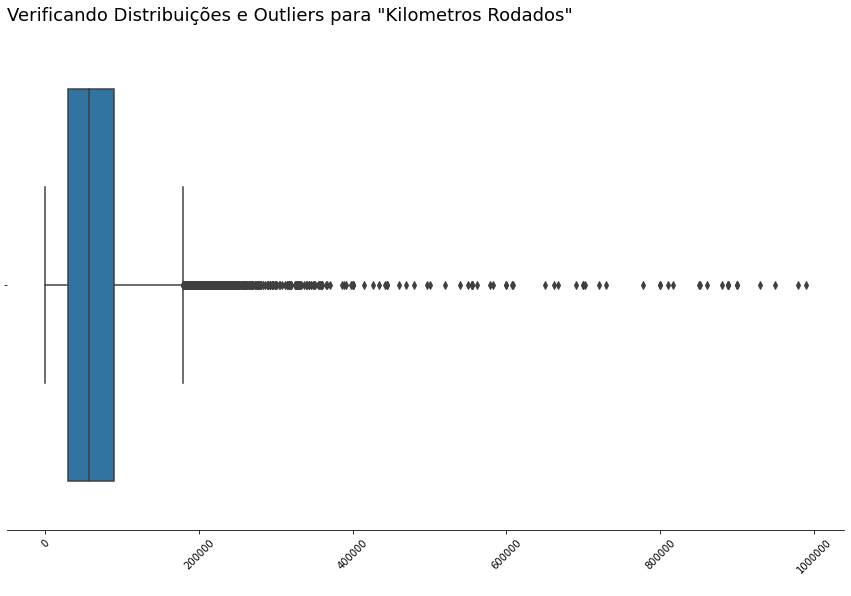

In [26]:
# Verificando resultado
box_km_tratado = sns.boxplot('km_veiculo', data=dados)
box_km_tratado.figure.set_size_inches(15,9)
plt.xlabel(' ')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Verificando Distribuições e Outliers para "Kilometros Rodados"', fontsize = 18, loc='left', pad =20)
sns.despine (left = True) 

In [27]:
# Explorando maiores valores dos outliers
dados['km_veiculo'].nlargest(50)

8135     990000
606      980000
27692    950000
26660    930000
17334    900000
44585    900000
25307    899999
21994    888888
22863    888888
25852    888888
37981    888888
39548    888888
46313    880000
25776    861233
26915    852006
18477    850000
10310    817000
12903    810000
44750    800000
45899    799999
27254    777777
19060    730000
16564    720000
28400    701700
39769    700003
16958    700000
35375    690000
36966    666666
8399     661768
8478     650000
36479    609179
8947     607190
6832     600000
32040    599000
14192    583000
48340    578996
12493    562163
5150     555555
20500    555555
22309    555555
35326    555555
37518    555555
38244    555555
46853    555555
47893    555555
10524    550000
2002     540000
22086    520000
29676    500000
12684    496322
Name: km_veiculo, dtype: int64

Para melhor refino, iremos excluir os dados com km > 999999, pois a quantidade de valores repetidos podem indicar algum problema de digitação ou erro de ingestão nos dados. Por enquato, iremos preservar os dados que podem ser considerados outliers naturais e veremos como os modelos se adequam a sua presença.

In [28]:
# Filtrando
dados = dados.query('km_veiculo <  999999')

In [29]:
# Conferindo resultado
dados['km_veiculo'].nlargest(20)

8135     990000
606      980000
27692    950000
26660    930000
17334    900000
44585    900000
25307    899999
21994    888888
22863    888888
25852    888888
37981    888888
39548    888888
46313    880000
25776    861233
26915    852006
18477    850000
10310    817000
12903    810000
44750    800000
45899    799999
Name: km_veiculo, dtype: int64

In [30]:
# Conferindo novo sumário estatístico
dados[colunas_describe].describe()

,leads,views,vlr_anuncio,vlr_mercado,km_veiculo,ano_modelo,cliques_telefone*
count,48347.000,48347.000,48347.000,48347.000,48347.000,48347.000,48347.000
mean,4.430,446.836,109735.599,51308.399,63222.811,2013.217,7.479
std,11.991,1107.701,2875782.730,39152.282,52142.713,4.743,11.475
min,0.000,0.000,3500.000,6292.844,0.000,1951.000,0.000
25%,1.000,76.000,30800.000,33042.308,29000.000,2011.000,2.000
50%,1.000,196.000,41490.000,40668.754,57000.000,2014.000,4.000
75%,4.000,452.000,64900.000,57328.453,89000.000,2016.000,9.000
max,364.000,93608.000,405000000.000,1111215.639,990000.000,2019.000,457.000


In [31]:
dados.columns

Index(['Unnamed: 0', 'cod_anuncio', 'cod_cliente', 'cod_tipo_pessoa',
       'prioridade', 'leads', 'views', 'cliques_telefone*',
       'cod_marca_veiculo', 'cod_modelo_veiculo', 'cod_versao_veiculo',
       'ano_modelo', 'cep_2dig', 'uf_cidade', 'vlr_anuncio', 'qtd_fotos',
       'km_veiculo', 'vlr_mercado', 'flg_unico_dono', 'flg_licenciado',
       'flg_ipva_pago', 'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_garantia_fabrica',
       'flg_blindado', 'flg_aceita_troca', 'flg_adaptado_pcd', 'combustivel',
       'cambio', 'portas', 'alarme', 'airbag', 'arquente', 'bancocouro',
       'arcondic', 'abs', 'desembtras', 'travaeletr', 'vidroseletr',
       'rodasliga', 'sensorchuva', 'sensorestacion', 'uf', 'cidade',
       'has_leads'],
      dtype='object')

As colunas `flg_ipva_pago` e `flg_todas_revisoes_concessionaria` acusam a exiestência de "nan" em algumas linhas. Tratar sua tiapgem resolve o problema.

In [32]:
dados['flg_todas_revisoes_concessionaria'].replace('nan', 0 , inplace=True)
dados['flg_todas_revisoes_concessionaria'] = dados['flg_todas_revisoes_concessionaria'].astype(float)
dados['flg_todas_revisoes_concessionaria'] = dados['flg_todas_revisoes_concessionaria'].astype(int)

In [33]:
dados['flg_ipva_pago'].replace('nan', 0 , inplace=True)
dados['flg_ipva_pago'] = dados['flg_ipva_pago'].astype(float)
dados['flg_ipva_pago'] = dados['flg_ipva_pago'].astype(int)

Considerações:
1. Ao comparar a `média` do valor de anúncio e valor de mercado, é possível notar que os valores anunciados em média são muito superiores aos valores praticados pela praça para aquele veículo. Este problema como visto na detecção de outliers anteriormente é derivado destes valores discrepantes de alguns anúncios. Desconsiderado este problema, a média de anúncio é aproximadamente R$ 109.279,00 e a média destes veículos na praça é R$ 51.212,84. As medianas, entretando, são mais próximas de R$ 40.000,00 como podemos ver nas comparações entre elas.

2. Em média, um anúncio possui cerca de 4 leads recebidos e 446 visualizações, o que nos dá uma proporção de que a cada 100 visualizações, 1 lead será gerado ao anunciante. 

3. Comparado os anúncios com mais geração de interesse (364 leads), podemos observar diferenças nas características dos veículos. Os veículos possuem valores de anúncio e de mercado discrepantes entre si, além de discrepâncias significativas entre características básicas como ano do modelo e kilometragem. No entanto, são similares enquanto a presência ou não de acessórios (travas eletétricas, ar condicionado e etc.)

4. Há anúncios com seu `vlr_anuncio` zerado. Em relação as kilometragens máximas registradas no dataset, possuimos vários anúncios com kilometragens irreais (por exemplo, veiculos com mais de 100 milhões de km rodados). Decidimos retirar estes valores para evitar problemas na modelagem preditiva, mas preservamos valores abaixo de 1 millhão de km rodados para manter eventuais outliers naturais na base. 

5. Por fim, em relação a distribuição interquartil dos dados, até 75% deles possuem 4 leads, 452 visualizações, valor de anúncio até R$ 64.888,00 de veículos com 89.000km rodados e 9 cliques no celular. 

Ao final, nosso dataset fica com a seguinte estrutura:

In [34]:
nova_esturutra = dados.shape
print(f'Após tratamento perdemos um total de {estrutura_original[0]-nova_esturutra[0]} linhas.')
print(f'A perda percentual de informação foi de {round((estrutura_original[0]-nova_esturutra[0])/len(dados)*100,2)}%')

Após tratamento perdemos um total de 2 linhas.
A perda percentual de informação foi de 0.0%


### Parte 1: Análise Exploratória dos Dados (EDA)

O objetivo agora é procurar por associações entre a quantidade de Leads gerados e algumas features de interesse

1) Quantos leads são gerados por marca e quais as mais relevantes?

In [35]:
# Gerando dados de interesse
leads_marca = pd.DataFrame(dados.groupby(['cod_marca_veiculo'])['leads'].sum()).reset_index()
leads_marca.rename(columns= {'cod_marca_veiculo' : 'Marca'}, inplace= True)
leads_marca.sort_values(by='leads',ascending=False)
leads_marca['percentual'] = leads_marca['leads'] / leads_marca['leads'].sum()*100
leads_marca

,Marca,leads,percentual
0,2,26745,12.487
1,3,18452,8.615
2,4,19674,9.185
3,5,27090,12.648
4,6,17,0.008
...,...,...,...
69,299,6,0.003
70,304,1,0.000
71,311,1,0.000
72,313,0,0.000


Para melhor visualização gráfica, iremos selecionar apenas as 20 maiores geradoras de leads por feature analisada.

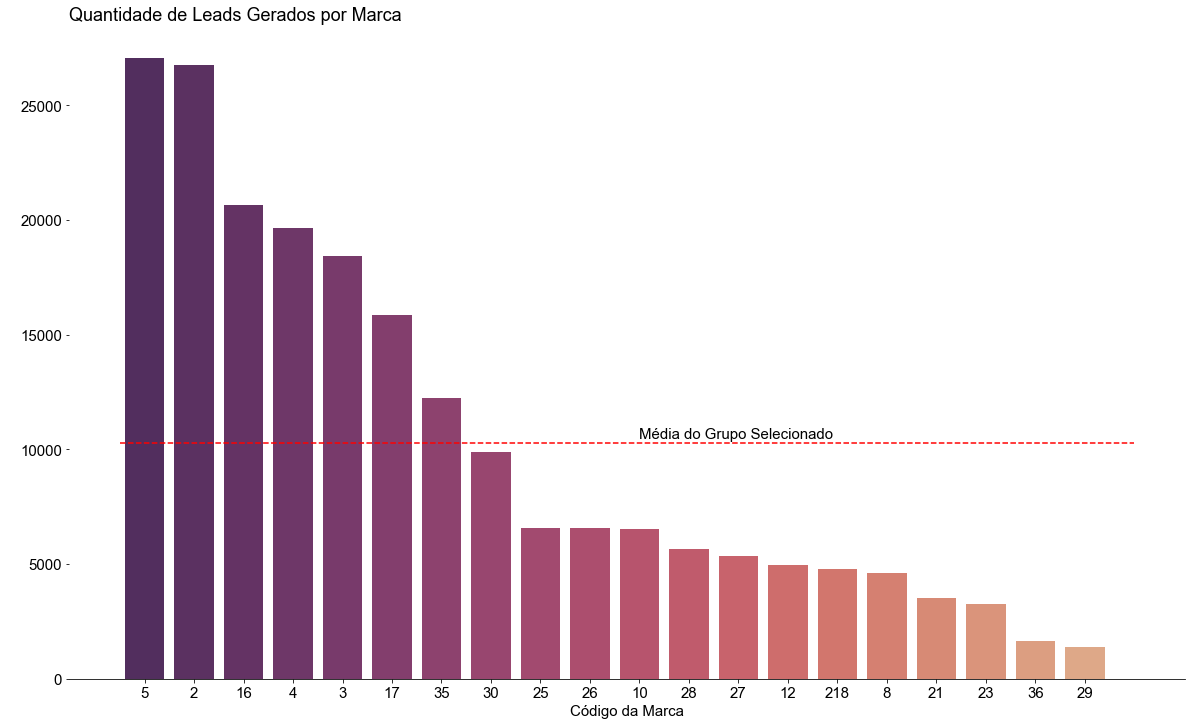

In [36]:
# Ordenando Dados para Aplicação visual
leads_marca = leads_marca.nlargest(20,columns='leads').sort_values(by='leads',ascending=False)

# Plotagem Gráfica: 
g1_marca = sns.barplot(x="Marca", y = 'leads', palette="flare_r", data=leads_marca, orient = "v", order=leads_marca['Marca'])
g1_marca.figure.set_size_inches(20,12)
plt.title('Quantidade de Leads Gerados por Marca', fontsize = 18, loc='left')
plt.ylabel(' ')
plt.xlabel('Código da Marca', fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.hlines(leads_marca['leads'].mean(), -0.5, 20, colors='red', linestyles='--')
plt.text(x=10, y=10500, s='Média do Grupo Selecionado', fontsize=15, alpha=1)
sns.despine (left = True)
sns.set_style('dark')

2) Quantos leads são gerados por modelo e quais os mais relevantes?

In [37]:
# Gerando dados de interesse
leads_modelo = pd.DataFrame(dados.groupby(['cod_modelo_veiculo'])['leads'].sum()).reset_index()
leads_modelo.rename(columns= {'cod_modelo_veiculo' : 'Modelo'}, inplace= True)
leads_modelo.sort_values(by='leads',ascending=False)

,Modelo,leads
21,690,7967
156,1194,5918
66,776,5407
44,740,4502
18,687,4499
...,...,...
236,2197,0
457,3185,0
362,2838,0
221,2151,0


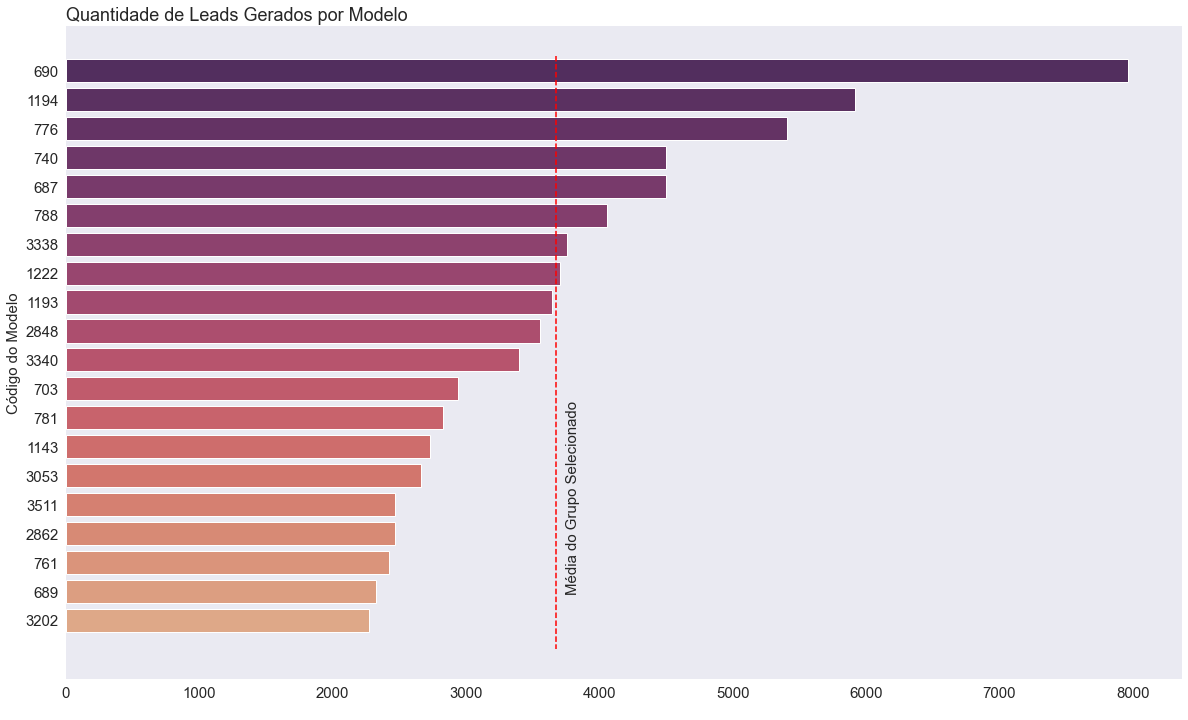

In [38]:
# Ordenando Dados para Aplicação visual
leads_modelo = leads_modelo.nlargest(20,columns='leads').sort_values(by='leads',ascending=False)

# Plotagem Gráfica: 
g2_modelo = sns.barplot(y="Modelo", x = 'leads', palette="flare_r", data=leads_modelo, orient = "h", order=leads_modelo['Modelo'])
g2_modelo.figure.set_size_inches(20,12)
plt.title('Quantidade de Leads Gerados por Modelo', fontsize = 18, loc='left')
plt.ylabel('Código do Modelo', fontsize=15)
plt.xlabel(' ')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.vlines(leads_modelo['leads'].mean(), -0.5, 20, colors='red', linestyles='--')
plt.text(x=3750, y=18, s='Média do Grupo Selecionado', fontsize=15, alpha=1, rotation = 90)
sns.despine (left = True)
sns.set_style('dark')

3) E por Estados, como estão as distribuições de leads gerados?


In [39]:
# Gerando dados de interesse
leads_uf = pd.DataFrame(dados.groupby(['uf'])['leads'].sum()).reset_index()
leads_uf.rename(columns= {'uf' : 'Estado'}, inplace= True)
leads_uf = leads_uf.sort_values(by='leads',ascending=False)
leads_uf['percentual_leads'] = leads_uf['leads'] / leads_uf['leads'].sum()*100
leads_uf.sort_values(inplace=True, by='percentual_leads', ascending=False)
leads_uf

,Estado,leads,percentual_leads
26,SP,151061,70.527
19,RJ,15175,7.085
10,MG,9906,4.625
18,PR,9509,4.440
24,SC,6532,3.050
23,RS,4772,2.228
6,DF,4305,2.010
8,GO,2388,1.115
4,BA,1612,0.753
16,PE,1362,0.636


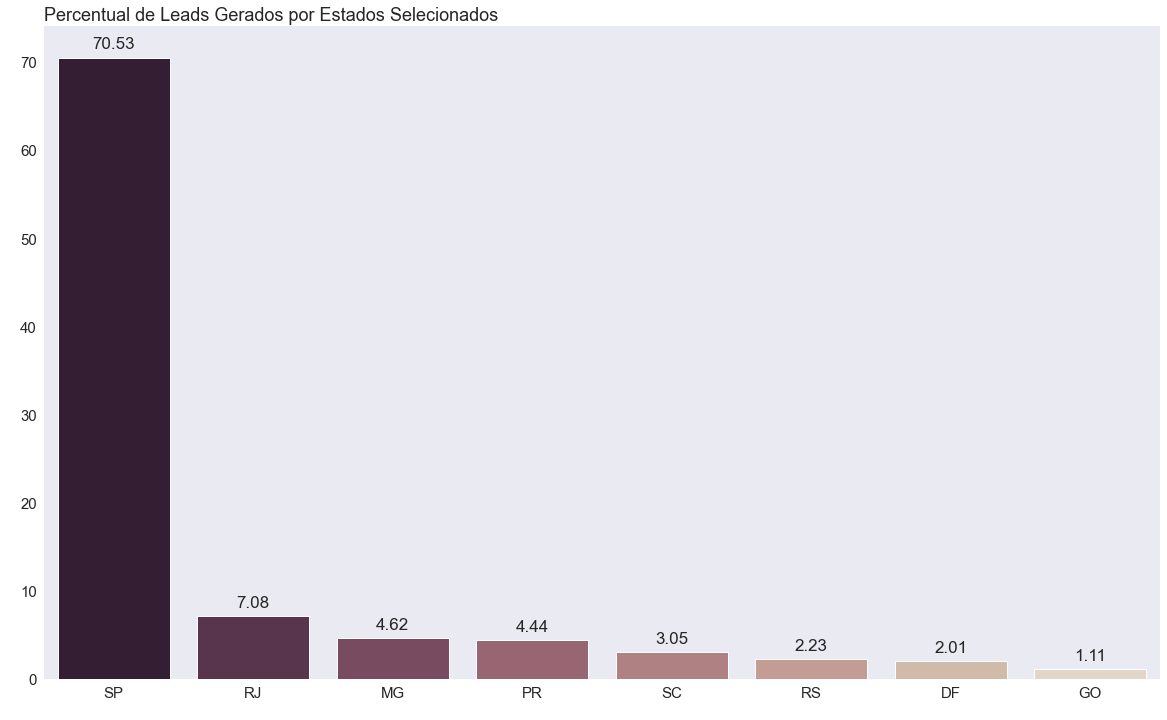

In [40]:
# Removendo N/A e filtrando Estados com % de leads acima de 1%
leads_uf = leads_uf.query('Estado != "N/A" and percentual_leads > 1')

# Plotagem Gráfica: 
g3_estado = sns.barplot(x="Estado", y = 'percentual_leads', palette="ch:.25_r", data=leads_uf, alpha=1)
g3_estado.figure.set_size_inches(20,12)
plt.title('Percentual de Leads Gerados por Estados Selecionados', fontsize = 18, loc='left')
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
sns.despine (left = True)
sns.set_style('dark')

# criando laço para rótulos
for p in g3_estado.patches:
    height = p.get_height()
    g3_estado.text(p.get_x()+p.get_width()/2., height+1, '{:1.2f}'.format(height), ha='center', fontsize = 17)

4. Verificando a situação por cidade

In [41]:
# Gerando dados de interesse
leads_cidade = pd.DataFrame(dados.groupby(['cidade'])['leads'].sum()).reset_index()
leads_cidade = leads_cidade.sort_values(by='leads',ascending=False)
leads_cidade['percentual'] = leads_cidade['leads'] / leads_cidade['leads'].sum()*100
leads_cidade.sort_values(inplace=True, by='percentual', ascending=False)
leads_cidade

,cidade,leads,percentual
820,SÃ£o Paulo,88629,41.379
702,Rio de Janeiro,11020,5.145
154,Campinas,7395,3.453
89,Belo Horizonte,5716,2.669
779,SÃ£o Bernardo do Campo,5248,2.450
...,...,...,...
354,IlhÃ©us,0,0.000
692,Rio Brilhante,0,0.000
562,NÃ£o se aplica,0,0.000
573,Pacajus,0,0.000


In [42]:
# Substituindo nomes das cidades de interesse na base original
leads_cidade['cidade'] = leads_cidade['cidade'].replace('SÃ£o Paulo','São Paulo')
leads_cidade['cidade'] = leads_cidade['cidade'].replace('SÃ£o Bernardo do Campo','São Bernado do Campo Paulo')
leads_cidade['cidade'] = leads_cidade['cidade'].replace('Santo AndrÃ©','Santo André')
leads_cidade['cidade'] = leads_cidade['cidade'].replace('BrasÃ\xadlia','Brasília')
leads_cidade['cidade'] = leads_cidade['cidade'].replace('SÃ£o JosÃ© do Rio Preto','São José do Rio Preto')
leads_cidade['cidade'] = leads_cidade['cidade'].replace('RibeirÃ£o Preto','Ribeirão Preto')
leads_cidade['cidade'] = leads_cidade['cidade'].replace('SÃ£o Caetano do Sul','São Caetano do Sul')

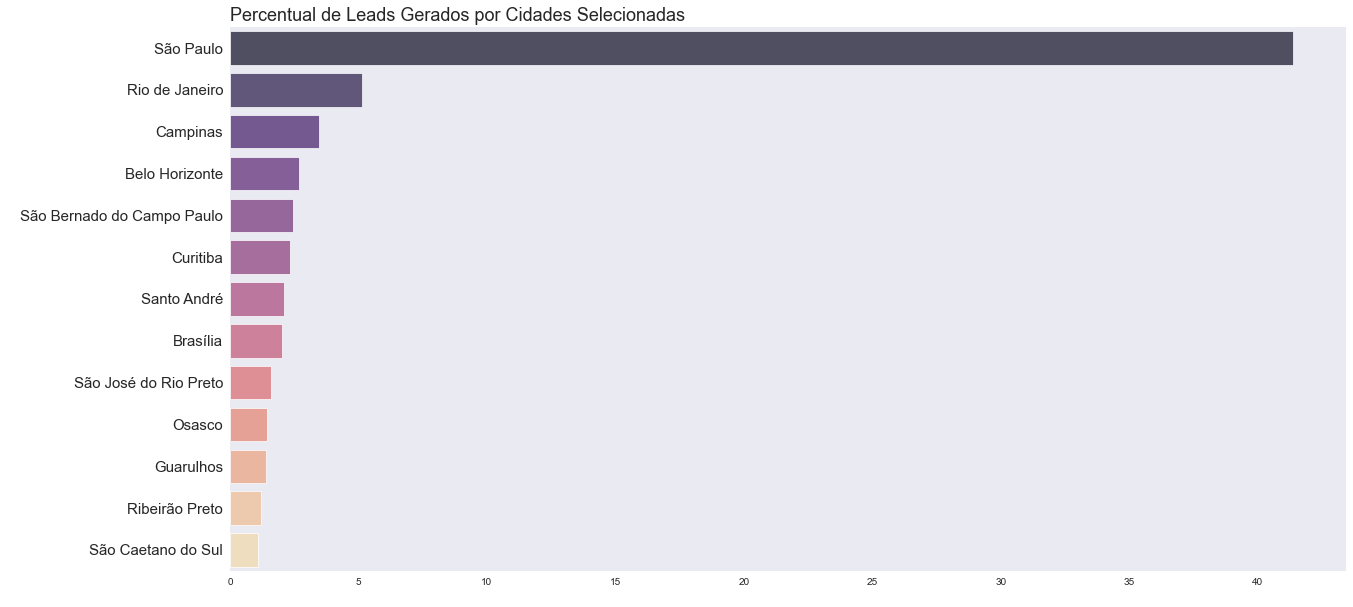

In [43]:
# Removendo N/A e filtrando Estados com % de leads acima de 1%
leads_cidade = leads_cidade.query('percentual > 1')

# Plotagem Gráfica: 
g4_cidade = sns.barplot(y="cidade", x = 'percentual', palette="magma", data=leads_cidade, alpha = 0.7)
g4_cidade.figure.set_size_inches(20,10)
plt.title('Percentual de Leads Gerados por Cidades Selecionadas', fontsize = 18, loc='left')
plt.ylabel(' ')
plt.xlabel(' ')
plt.yticks(fontsize = 15)
sns.despine (left = True)
sns.set_style('dark')

Obs: É esperado que grandes Estados e Cidades possuam grande quantidade de leads e views por causa de sua população. Para tal, iremos comparar a quantidade de ANÚNCIOS vs a quantidade de LEADS por cidade para verificarmos possíveis dissonâncias entre estas duas variáveis

In [44]:
qtde_anuncios_uf = pd.DataFrame(dados.groupby(['uf']).size()).reset_index()
qtde_anuncios_uf.rename(columns= {'uf' : 'Estado', 0 : 'Quantidade de Anúncios'}, inplace= True)
qtde_anuncios_uf = qtde_anuncios_uf.sort_values(by='Quantidade de Anúncios',ascending=False)
qtde_anuncios_uf['percentual_anuncios'] = qtde_anuncios_uf['Quantidade de Anúncios'] / qtde_anuncios_uf['Quantidade de Anúncios'].sum()*100
qtde_anuncios_uf = qtde_anuncios_uf.query('Estado != "N/A"')
qtde_anuncios_uf

,Estado,Quantidade de Anúncios,percentual_anuncios
26,SP,22836,47.234
18,PR,4379,9.057
24,SC,3719,7.692
19,RJ,3714,7.682
10,MG,3228,6.677
23,RS,2543,5.260
6,DF,1757,3.634
8,GO,929,1.922
16,PE,771,1.595
4,BA,628,1.299


In [45]:
# Unindo base das quantidade de Anuncios e Leads por UF

anuncios_leads_uf = pd.merge(leads_uf, qtde_anuncios_uf, left_on='Estado', right_on = 'Estado')
anuncios_leads_uf.query('Estado != "N/A" and leads > 400', inplace=True)
anuncios_leads_uf = anuncios_leads_uf.nlargest(10, columns='Quantidade de Anúncios') 
anuncios_leads_uf # conferindo

,Estado,leads,percentual_leads,Quantidade de Anúncios,percentual_anuncios
0,SP,151061,70.527,22836,47.234
3,PR,9509,4.440,4379,9.057
4,SC,6532,3.050,3719,7.692
1,RJ,15175,7.085,3714,7.682
2,MG,9906,4.625,3228,6.677
5,RS,4772,2.228,2543,5.260
6,DF,4305,2.010,1757,3.634
7,GO,2388,1.115,929,1.922


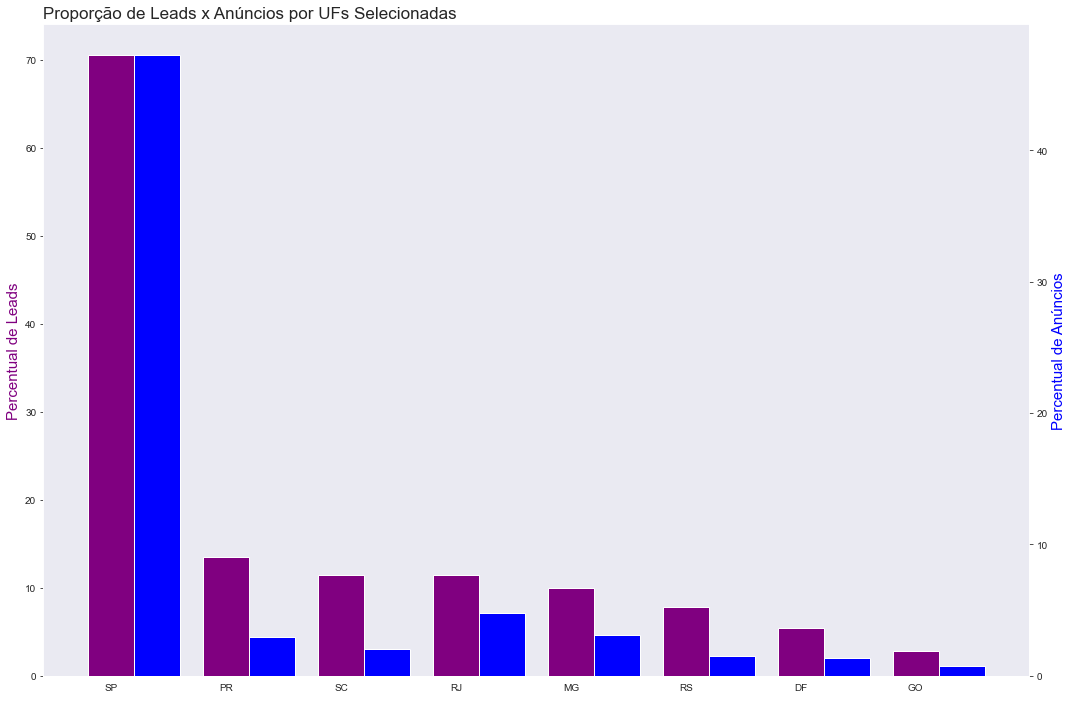

In [46]:
# Plotagem gráfica

x = anuncios_leads_uf['Estado'] 
y1 = anuncios_leads_uf['percentual_leads']
y2 = anuncios_leads_uf['percentual_anuncios']
fig, ax = plt.subplots(figsize = (15, 10)) 
plt.title('Proporção de Leads x Anúncios por UFs Selecionadas', fontsize=17, loc='left') 
ax2 = ax.twinx() 
ax.bar(x, y1, color = 'blue', align='edge', width=0.6) 
ax2.bar(x, y2, color = 'purple', width=0.4) 
ax.set_xlabel(' ') 
ax.set_ylabel('Percentual de Leads', color = 'purple',fontsize=15)
ax2.set_ylabel('Percentual de Anúncios', color = 'blue',fontsize=15) 
plt.tight_layout() 
plt.show() 

5. Em relação ao ano do veículo, quais as quantidades de leads gerados?

In [47]:
# Gerando dados de interesse
leads_anoModelo = pd.DataFrame(dados.groupby(['ano_modelo'])['leads'].sum()).reset_index()
leads_anoModelo.rename(columns= {'ano_modelo' : 'Ano Modelo'}, inplace= True)
leads_anoModelo = leads_anoModelo.sort_values(by='leads',ascending=False)
leads_anoModelo

,Ano Modelo,leads
58,2015,24461
57,2014,24049
56,2013,22186
55,2012,19488
60,2017,18160
...,...,...
6,1963,2
4,1961,2
7,1964,1
3,1959,1


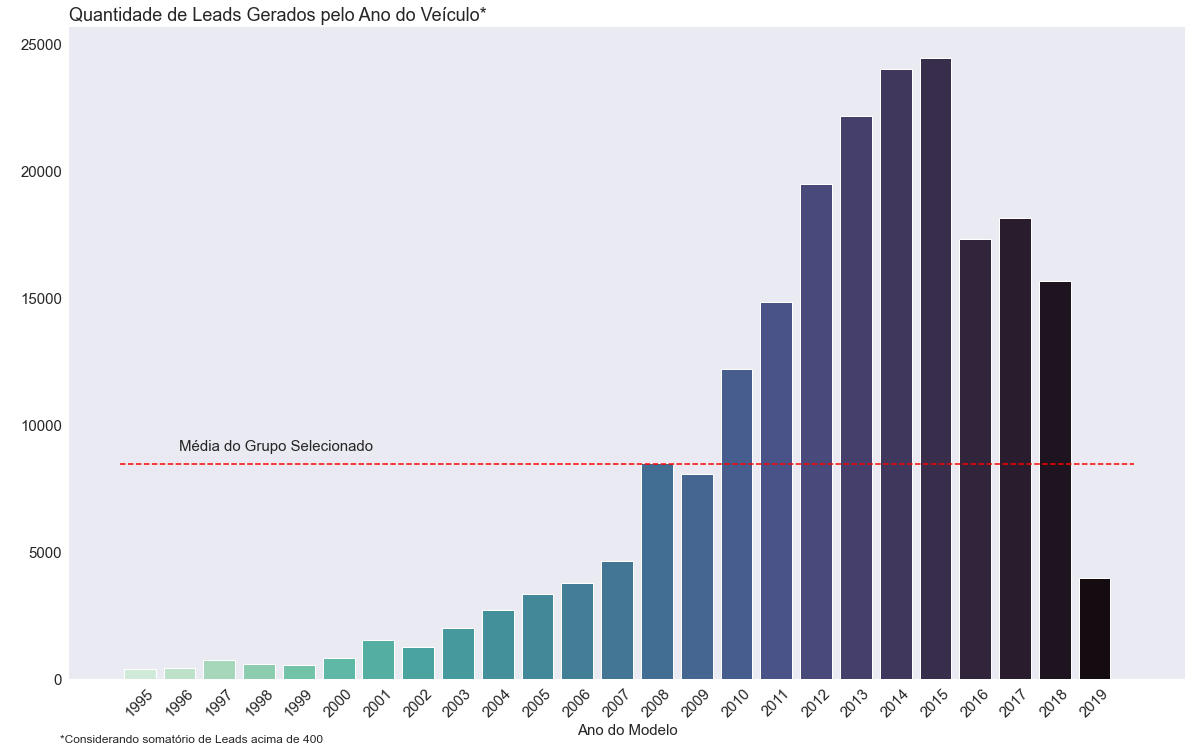

In [48]:
# Ordenando Dados para Aplicação visual
leads_anoModelo = leads_anoModelo.query('leads > 400')
# Plotagem Gráfica: 
g5_anoModelo = sns.barplot(x="Ano Modelo", y = 'leads', palette="mako_r", data=leads_anoModelo, orient = "v", alpha = 1)
g5_anoModelo.figure.set_size_inches(20,12)
plt.title('Quantidade de Leads Gerados pelo Ano do Veículo*', fontsize = 18, loc='left')
plt.ylabel(' ')
plt.xlabel('Ano do Modelo', fontsize=15)
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)
plt.hlines(leads_anoModelo['leads'].mean(), -0.5, 25, colors='red', linestyles='--')
plt.text(x=1, y=9000, s='Média do Grupo Selecionado', fontsize=15, alpha=1)
plt.text(x=-2, y=-2500, s='*Considerando somatório de Leads acima de 400', fontsize=12, alpha=1)
sns.despine (left = True)
sns.set_style('dark')

6. Com base no modelo, quais as quantidades de visualizações dos anúncios e leads?

In [49]:
# Gerando dados de interesse
leads_views_prio = pd.DataFrame(dados.groupby(['prioridade'])['views','leads'].sum().reset_index())
leads_views_prio = leads_views_prio.sort_values(by='leads')

In [50]:
# Renomenado registros
leads_views_prio['prioridade'] = leads_views_prio['prioridade'].replace(1,'Baixa')
leads_views_prio['prioridade'] = leads_views_prio['prioridade'].replace(2,'Média')
leads_views_prio['prioridade'] = leads_views_prio['prioridade'].replace(3,'Alta')

In [51]:
leads_views_prio.head()

,prioridade,views,leads
1,Média,706124,24723
0,Baixa,3431396,63290
2,Alta,17465644,126176


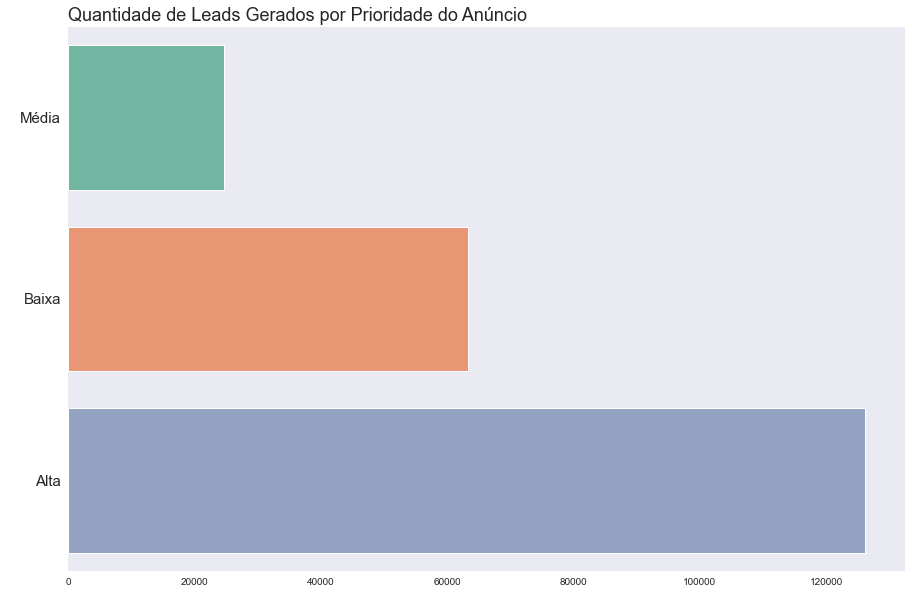

In [52]:
# Plot gráfico:

g6_prioridades = sns.barplot(y="prioridade", x = 'leads', palette='Set2', data=leads_views_prio, orient = "h")
g6_prioridades.figure.set_size_inches(15,10)
plt.title('Quantidade de Leads Gerados por Prioridade do Anúncio', fontsize = 18, loc='left')
plt.ylabel(' ')
plt.xlabel(' ')
plt.yticks(fontsize = 15)
sns.despine (left = True)
sns.set_style('dark')

As prioridades dos anúncios impactam nas visualizações dos mesmos?

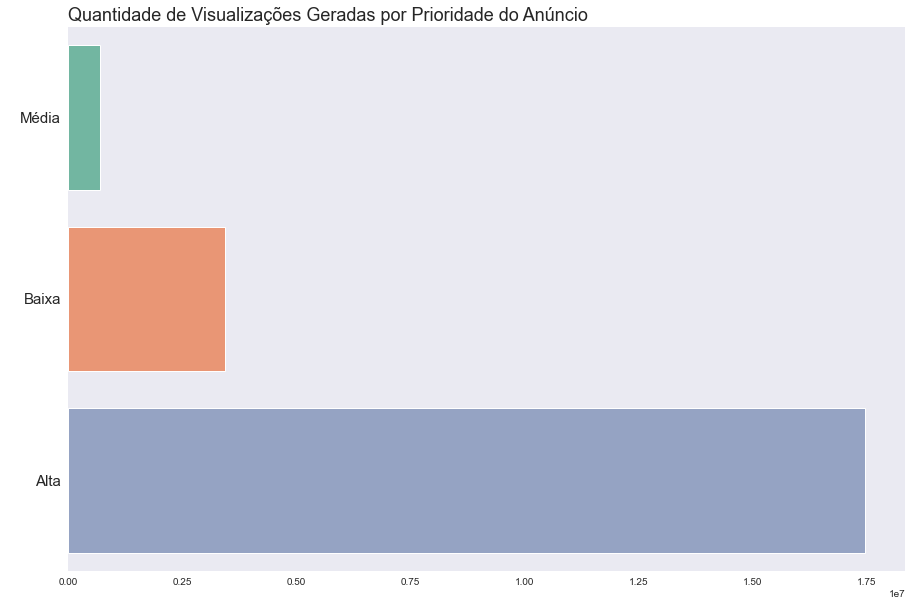

In [53]:
# Plot:
g7_prioridades = sns.barplot(y="prioridade", x = 'views', palette='Set2', data=leads_views_prio, orient = "h")
g7_prioridades.figure.set_size_inches(15,10)
plt.title('Quantidade de Visualizações Geradas por Prioridade do Anúncio', fontsize = 18, loc='left')
plt.ylabel(' ')
plt.xlabel(' ')
plt.yticks(fontsize = 15)
sns.despine (left = True)
sns.set_style('dark')

In [54]:
dados['prioridade'].value_counts()

3    37490
1     8492
2     2365
Name: prioridade, dtype: int64

### Impressões e Considerações:

1. Levando em consideração a geração de leads, a marca do veículo e seu modelo influenciam na quantidade de interesse produzido. Podemos observar esta informação nos gráficos 1 e 2, que mostram o somatório de leads que cada marca e modelo produzem em relação a média do grupo. Vale observar que esta média é calculada com base no filtro aplicado para gerar este gráfico, ou seja, a média de leads das 20 maiores respectivas características. Possuímos apenas 7 marcas e 8 modelos que performam acima da média de geração de leads e elas são responsavéis pelo maior percentual de interesse gerados em suas respectivas categorias. 

2. Analisando geograficamente podemos constatar a larga predominância do Estado e da Cidade de São Paulo na geração de leads dos anúncios. Mais de 70% dos Leads gerados estão no Estado de São Paulo quando comparado com os demais Estados, similiar as comparações entre a cidade de São Paulo e demais municípios. Ao comparar a quantidade de anúncios e leads gerados por UF, podemos perceber que a ordem não inverte, e São paulo segue sendo o Estado com mais anúncios criados e leads gerados. Neste ponto, Paraná possui maior quantidade de anúncios que Rio de Janeiro e Minas Gerais, mas menor número de leads gerados pelos seus pares.

3. Quando analisamos o ano do veículo anunciado algumas informações importantes devem ser destacadas. Carros com modelos abaixo de 2009 geram uma menor quantidade de leads, e isto é mais intenso para modelos abaixo do ano 2000. Do gráfico 5, podemos inferir que modelos entre 2010 e 2018 possuem a maior taxa de geração de interesse, sendo os únicos exemplares a ficarem significativamente acima da média do grupo. Para este exemplo, filtramos apenas os modelos com leads > 400 para melhor apresentação visual. 

4. Por fim, levando em consideração a prioridade dos anúncios podemos observar que há uma alta predominância de Leads e Visualizações naqueles anúncios de baixa prioridade em relação aos de média e alta. Isto é um problema? Aparentemente não, haja vista que a grande maioria dos anúncios do dataset sejam da categoria 'baixa prioridade', o que por si só poderia explicar este padrão observado. 

## Parte 2: Modelagem dos Classificadores e Regressores

### Feature engineering:

Objetivos:

1. Target enconding para features com alta cardinalidade

2. Aplicar método de Mutual Information para selecionar features com maior poder preditivo

3. Criar novas features baseadas em agrupamento de anúncios (kmeans) 

In [55]:
dados.columns

Index(['Unnamed: 0', 'cod_anuncio', 'cod_cliente', 'cod_tipo_pessoa',
       'prioridade', 'leads', 'views', 'cliques_telefone*',
       'cod_marca_veiculo', 'cod_modelo_veiculo', 'cod_versao_veiculo',
       'ano_modelo', 'cep_2dig', 'uf_cidade', 'vlr_anuncio', 'qtd_fotos',
       'km_veiculo', 'vlr_mercado', 'flg_unico_dono', 'flg_licenciado',
       'flg_ipva_pago', 'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_garantia_fabrica',
       'flg_blindado', 'flg_aceita_troca', 'flg_adaptado_pcd', 'combustivel',
       'cambio', 'portas', 'alarme', 'airbag', 'arquente', 'bancocouro',
       'arcondic', 'abs', 'desembtras', 'travaeletr', 'vidroseletr',
       'rodasliga', 'sensorchuva', 'sensorestacion', 'uf', 'cidade',
       'has_leads'],
      dtype='object')

In [56]:
# removendo colunas que nao adicionam informação relevante
dados.drop(['uf_cidade','cod_anuncio','cod_cliente','cod_tipo_pessoa','cod_versao_veiculo','cep_2dig','Unnamed: 0'],axis=1,inplace=True)

### Objetivo 1: Target encoding para features de alta cardinalidade (n_class > 15)

Iremos aplicar transformações aplicando a média de leads gerados por Cidade, Uf, Combustível, Marca e Modelo do anúncio pelo método de Smoothing.

Obs: Para aplicação desta técnica é necessário sacrificar uma parte dos dados para o devido treinamento do encoding (e evitar overfitting). Iremos utilizar 20% dos dados para este objetivo, portanto o treinamento posterior do nosso modelo será feito com um dataset de 75% do tamanho do dataset original

In [57]:
dados['has_leads'] = np.where(dados['leads']>0, 1, 0)

In [58]:
from category_encoders import MEstimateEncoder

dados.select_dtypes(["object"]).nunique()

flg_garantia_fabrica      3
flg_adaptado_pcd          3
combustivel              10
cambio                    7
portas                    4
alarme                    2
airbag                    3
arquente                  2
bancocouro                2
arcondic                  2
abs                       2
desembtras                2
travaeletr                2
vidroseletr               2
rodasliga                 2
sensorchuva               2
sensorestacion            2
uf                       28
cidade                  927
dtype: int64

In [59]:
dados.columns

Index(['prioridade', 'leads', 'views', 'cliques_telefone*',
       'cod_marca_veiculo', 'cod_modelo_veiculo', 'ano_modelo', 'vlr_anuncio',
       'qtd_fotos', 'km_veiculo', 'vlr_mercado', 'flg_unico_dono',
       'flg_licenciado', 'flg_ipva_pago', 'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_garantia_fabrica',
       'flg_blindado', 'flg_aceita_troca', 'flg_adaptado_pcd', 'combustivel',
       'cambio', 'portas', 'alarme', 'airbag', 'arquente', 'bancocouro',
       'arcondic', 'abs', 'desembtras', 'travaeletr', 'vidroseletr',
       'rodasliga', 'sensorchuva', 'sensorestacion', 'uf', 'cidade',
       'has_leads'],
      dtype='object')

In [60]:
# Alterando tipagem de Marca e Modelo para object

filtro = ['cod_marca_veiculo','cod_modelo_veiculo'] # criando filtro
dados[filtro] = dados[filtro].astype(object) # aplicando transformação
dados.select_dtypes(["object"]).nunique()

cod_marca_veiculo        74
cod_modelo_veiculo      655
flg_garantia_fabrica      3
flg_adaptado_pcd          3
combustivel              10
cambio                    7
portas                    4
alarme                    2
airbag                    3
arquente                  2
bancocouro                2
arcondic                  2
abs                       2
desembtras                2
travaeletr                2
vidroseletr               2
rodasliga                 2
sensorchuva               2
sensorestacion            2
uf                       28
cidade                  927
dtype: int64

In [61]:
# Separação dos dados para o encoding (20%  dataset)
X_encode = dados.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("leads")

# Separação para treinar o encoder (75% dataset)
X_pretrain = dados.drop(X_encode.index)
y = X_pretrain.pop("leads")

# Selecionando features a serem transformadas e configurando a suaviação (m)
encoder = MEstimateEncoder(cols=['cidade','combustivel','cod_marca_veiculo','cod_modelo_veiculo','uf'], m=5)

# Realizando fit
encoder.fit(X_encode,y_encode)

# Aplicando transformação nos dados de treino
X = encoder.transform(X_pretrain, y)

In [62]:
# Agora nossos dados possuem valores médios ponderados de leads gerados para as features transformadas
X.head()

,prioridade,views,cliques_telefone*,cod_marca_veiculo,cod_modelo_veiculo,ano_modelo,vlr_anuncio,qtd_fotos,km_veiculo,vlr_mercado,...,abs,desembtras,travaeletr,vidroseletr,rodasliga,sensorchuva,sensorestacion,uf,cidade,has_leads
1,3,0,11,2.539,4.968,2002,38800.000,4,33700,40668.754,...,S,S,S,S,S,N,N,6.707,10.422,1
2,2,0,14,6.504,3.720,1995,44000.000,8,105000,40668.754,...,N,N,S,S,S,N,N,6.707,10.422,1
3,2,0,11,3.460,4.496,1995,30000.000,6,71240,40668.754,...,S,S,S,S,S,N,N,6.707,10.422,1
5,2,0,4,3.835,3.312,2000,16000.000,4,0,40668.754,...,N,S,S,S,N,N,N,6.707,10.422,1
6,2,0,0,5.144,7.240,1998,26000.000,4,0,40668.754,...,S,S,S,S,S,N,N,6.707,10.422,1


### Objetivo 2: Seleção de features com Mutual Information

In [63]:
from sklearn.feature_selection import mutual_info_regression

# Definindo função para calculo do score de M.I
def calculo_mi_score(X, y):
    X = X.drop(['has_leads'],axis=1)
    # Todas as variáveis categorias devem ter valor discreto
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # Forçando que as variáveis discretas tenham valores inteiros
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    # Instanciando método de M.I e retornando valores em order decrescente  
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = calculo_mi_score(X, y)
print(mi_scores)

cliques_telefone*                   0.236
km_veiculo                          0.193
views                               0.114
cidade                              0.049
uf                                  0.031
flg_aceita_troca                    0.030
flg_licenciado                      0.028
prioridade                          0.026
flg_ipva_pago                       0.025
cod_marca_veiculo                   0.016
flg_todas_revisoes_agenda_veiculo   0.016
flg_todas_revisoes_concessionaria   0.015
combustivel                         0.015
cod_modelo_veiculo                  0.013
vlr_anuncio                         0.012
vlr_mercado                         0.012
qtd_fotos                           0.011
bancocouro                          0.009
flg_unico_dono                      0.009
ano_modelo                          0.008
cambio                              0.007
rodasliga                           0.007
alarme                              0.006
sensorchuva                       

Iremos exluir do nosso dataset aquelas features com `mi_score` menores que 0.01, pois elas adicionam pouca ou nenhuma informação ao nosso target

In [64]:
X.drop(['cambio', 'ano_modelo','bancocouro','flg_garantia_fabrica','alarme','arquente',\
'flg_unico_dono','sensorchuva','desembtras','rodasliga','flg_blindado','portas','flg_adaptado_pcd',\
'airbag','sensorestacion','vidroseletr','travaeletr','abs','arcondic'],axis=1,inplace=True)

### Objetivo 3: Utilizando Kmeans para criar features com base em grupos de anúncios similares

In [65]:
X.columns

Index(['prioridade', 'views', 'cliques_telefone*', 'cod_marca_veiculo',
       'cod_modelo_veiculo', 'vlr_anuncio', 'qtd_fotos', 'km_veiculo',
       'vlr_mercado', 'flg_licenciado', 'flg_ipva_pago',
       'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_aceita_troca', 'combustivel',
       'uf', 'cidade', 'has_leads'],
      dtype='object')

In [66]:
from sklearn.cluster import KMeans
features = X.columns

# Aplicando padronização: kmeans é sensivel as escalas
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

X_scaled.fillna(0,axis=0,inplace=True) # a transformação cria zeros e o phyton reconhece como NaN

# Realizando Fit
kmeans = KMeans(n_clusters=5, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)
X["Cluster"].head()

1    0
2    3
3    0
5    3
6    0
Name: Cluster, dtype: int32

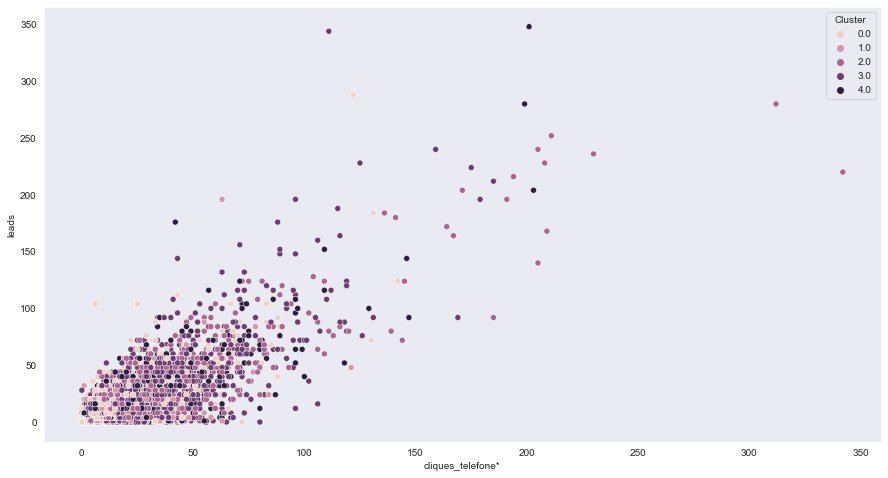

In [67]:
# Relação entre o target e a principal feature de mi_score por Cluster
g1 = sns.scatterplot(y='leads',x='cliques_telefone*',data=dados,hue=X['Cluster'])
g1.figure.set_size_inches(15,8)


### Criação e Validação dos Modelos

Disclaimer: iremos utilizar o método de validação cruzada estratificada, pois nosso target é desbalanceado. Pelo mesmo motivo iremos utilizar a métrica de ``f1score`` e ``AUPRC`` para os modelos de classificação. 

Objetivos:

1. Primeiro irmeos construir um modelo de classificação para prever se um anúncio terá um lead ou não;

2. Depois criaremos um modelo que seja capaz de prever a quantidade de lead gerado por anúncio.

In [68]:
# Redefinindo o target para a variável has_leads
y = X_pretrain.pop("has_leads")

In [69]:
# Aplicando split (valerá para todos os modelos)
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report

separador = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

for treino_index, val_index in separador.split(X, y):
  X_treino, X_teste = X.iloc[treino_index, :], X.iloc[val_index, :]
  y_treino, y_teste = y.iloc[treino_index], y.iloc[val_index]

### Modelos de Classificação: 

1. Iremos criar múltiplos modelos baseado em árvores, distância e linear para comparar desempenho.

1º MODELO: RandomForest

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado + scaler (normalização)
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())
])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 1º modelo de Classificação
modelo_RF = RandomForestClassifier(random_state=0)

# Criando pipeline (transformadores + modelo)
pipeline_RF = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_RF)
                             ])

In [71]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_acuracias = []
lista_f1_scores = []
lista_aupcr_scores = []

for train_index, val_index in separador.split(X, y):
    X_treino, X_teste = X.iloc[train_index, :], X.iloc[val_index, :]
    y_treino, y_teste = y.iloc[train_index], y.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_RF.fit(X_treino, y_treino)
      previsao = pipeline_RF.predict(X_teste)
      
      # Calculando métricas para cada rodada
      acc = accuracy_score(y_teste, previsao)
      lista_acuracias.append(acc)

      _f1_score = f1_score(y_teste, previsao, average='weighted')
      lista_f1_scores.append(_f1_score)

      aupcr_score = average_precision_score(y_teste, previsao, average='weighted')
      lista_aupcr_scores.append(aupcr_score)
      
print("Treinamento Concluído")

Treinamento Concluído


In [72]:
# Calculando média e desvio padrão de acurácia das execuções
acc_forest, acc_std_forest = np.array(lista_acuracias).mean(), \
  np.array(lista_acuracias).std()
print(f'A acurácia média entre as execuções foi de {round(acc_forest*100,2)}% com desvio padrão de {round(acc_std_forest,4)}')

 #Calculando média e desvio padrão de f1score das execuções
f1_forest, f1_std_forest = np.array(lista_f1_scores).mean(),\
 np.array(lista_f1_scores).std()
print(f'O F1score médio entre as execuções foi de {round(f1_forest*100,2)}% com desvio padrão de {round(f1_std_forest,4)}')

# Calculando média e desvio padrão de AUPRC das execuções
aupcr_forest, aupcr_std_forest = np.array(lista_aupcr_scores).mean(),\
 np.array(lista_aupcr_scores).std()
print(f'O AUPRC entre as execuções foi de {round(aupcr_forest*100,2)}% com desvio padrão de {round(aupcr_std_forest,4)}')

A acurácia média entre as execuções foi de 77.85% com desvio padrão de 0.0005
O F1score médio entre as execuções foi de 68.89% com desvio padrão de 0.0006
O AUPRC entre as execuções foi de 78.26% com desvio padrão de 0.0002


In [73]:
# verificando a distribuição de previsões entre as classes
pd.Series(previsao).value_counts()

1    9591
0      78
dtype: int64

Avaliando o desempenho do modelo RandomForest

In [74]:
print(classification_report(y_teste, previsao))

              precision    recall  f1-score   support

           0       0.28      0.01      0.02      2107
           1       0.78      0.99      0.88      7562

    accuracy                           0.78      9669
   macro avg       0.53      0.50      0.45      9669
weighted avg       0.67      0.78      0.69      9669



2º Modelo: Regressão Logistica

In [75]:
from sklearn.linear_model import LogisticRegression

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado, mas instacioamos aqui a normalização dos dados também
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 2º modelo de Classificação
modelo_RL = LogisticRegression(random_state=0,penalty='l2', class_weight='balanced')

# Criando pipeline (transformadores + modelo)
pipeline_RL = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_RL)
                             ])

In [76]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_acuracias = []
lista_f1_scores = []
lista_aupcr_scores = []

for train_index, val_index in separador.split(X, y):
    X_treino, X_teste = X.iloc[train_index, :], X.iloc[val_index, :]
    y_treino, y_teste = y.iloc[train_index], y.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_RL.fit(X_treino, y_treino)
      previsao = pipeline_RL.predict(X_teste)
      
      # Calculando métricas para cada rodada
      acc = accuracy_score(y_teste, previsao)
      lista_acuracias.append(acc)

      _f1_score = f1_score(y_teste, previsao, average='weighted')
      lista_f1_scores.append(_f1_score)

      aupcr_score = average_precision_score(y_teste, previsao, average='weighted')
      lista_aupcr_scores.append(aupcr_score)
      
print("Treinamento Concluído")

Treinamento Concluído


In [77]:
# Calculando média e desvio padrão de acurácia das execuções
acc_logistica, acc_std_logistica = np.array(lista_acuracias).mean(), \
  np.array(lista_acuracias).std()
print(f'A acurácia média entre as execuções foi de {round(acc_logistica*100,2)}% com desvio padrão de {round(acc_std_logistica,4)}')

 #Calculando média e desvio padrão de f1score das execuções
f1_logistica, f1_std_logistica = np.array(lista_f1_scores).mean(),\
 np.array(lista_f1_scores).std()
print(f'O F1score médio entre as execuções foi de {round(f1_logistica*100,2)}% com desvio padrão de {round(f1_std_logistica,4)}')

# Calculando média e desvio padrão de AUPRC das execuções
aupcr_logistica, aupcr_std_logistica = np.array(lista_aupcr_scores).mean(),\
 np.array(lista_aupcr_scores).std()
print(f'O AUPRC entre as execuções foi de {round(aupcr_logistica*100,2)}% com desvio padrão de {round(aupcr_std_logistica,4)}')

A acurácia média entre as execuções foi de 50.91% com desvio padrão de 0.0013
O F1score médio entre as execuções foi de 54.64% com desvio padrão de 0.002
O AUPRC entre as execuções foi de 81.17% com desvio padrão de 0.002


In [78]:
# verificando a distribuição de previsões entre as classes
pd.Series(previsao).value_counts()

0    5613
1    4056
dtype: int64

Avaliando o desempenho do modelo de Regressão Logistica

In [79]:
print(classification_report(y_teste, previsao))

              precision    recall  f1-score   support

           0       0.26      0.70      0.38      2107
           1       0.85      0.45      0.59      7562

    accuracy                           0.51      9669
   macro avg       0.56      0.58      0.49      9669
weighted avg       0.72      0.51      0.55      9669



3º MODELO: KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado, mas instacioamos aqui a normalização dos dados também
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 2º modelo de Classificação
modelo_KNN = KNeighborsClassifier(n_neighbors=5)

# Criando pipeline (transformadores + modelo)
pipeline_KNN = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_KNN)
                             ])

In [81]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_acuracias = []
lista_f1_scores = []
lista_aupcr_scores = []

for train_index, val_index in separador.split(X, y):
    X_treino, X_teste = X.iloc[train_index, :], X.iloc[val_index, :]
    y_treino, y_teste = y.iloc[train_index], y.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_KNN.fit(X_treino, y_treino)
      previsao = pipeline_KNN.predict(X_teste)
      
      # Calculando métricas para cada rodada
      acc = accuracy_score(y_teste, previsao)
      lista_acuracias.append(acc)

      _f1_score = f1_score(y_teste, previsao, average='weighted')
      lista_f1_scores.append(_f1_score)

      aupcr_score = average_precision_score(y_teste, previsao, average='weighted')
      lista_aupcr_scores.append(aupcr_score)
      
print("Treinamento Concluído")

Treinamento Concluído


In [82]:
# Calculando média e desvio padrão de acurácia das execuções
acc_knn, acc_std_knn = np.array(lista_acuracias).mean(), \
  np.array(lista_acuracias).std()
print(f'A acurácia média entre as execuções foi de {round(acc_knn*100,2)}% com desvio padrão de {round(acc_std_knn,4)}')

 #Calculando média e desvio padrão de f1score das execuções
f1_knn, f1_std_knn = np.array(lista_f1_scores).mean(),\
 np.array(lista_f1_scores).std()
print(f'O F1score médio entre as execuções foi de {round(f1_knn*100,2)}% com desvio padrão de {round(f1_std_knn,4)}')

# Calculando média e desvio padrão de AUPRC das execuções
aupcr_knn, aupcr_std_knn = np.array(lista_aupcr_scores).mean(),\
 np.array(lista_aupcr_scores).std()
print(f'O AUPRC entre as execuções foi de {round(aupcr_knn*100,2)}% com desvio padrão de {round(aupcr_std_knn,4)}')

A acurácia média entre as execuções foi de 73.85% com desvio padrão de 0.0024
O F1score médio entre as execuções foi de 69.17% com desvio padrão de 0.0023
O AUPRC entre as execuções foi de 78.45% com desvio padrão de 0.001


In [83]:
# verificando a distribuição de previsões entre as classes
pd.Series(previsao).value_counts()

1    8849
0     820
dtype: int64

In [84]:
print(classification_report(y_teste, previsao))

              precision    recall  f1-score   support

           0       0.26      0.10      0.14      2107
           1       0.79      0.92      0.85      7562

    accuracy                           0.74      9669
   macro avg       0.52      0.51      0.50      9669
weighted avg       0.67      0.74      0.69      9669



4º MODELO: Naive Bayes

In [85]:
from sklearn.naive_bayes import GaussianNB

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino.columns if X_treino[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado, mas instacioamos aqui a normalização dos dados também
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 2º modelo de Classificação
modelo_NB = GaussianNB()

# Criando pipeline (transformadores + modelo)
pipeline_NB = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_NB)
                             ])

In [86]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_acuracias = []
lista_f1_scores = []
lista_aupcr_scores = []

for train_index, val_index in separador.split(X, y):
    X_treino, X_teste = X.iloc[train_index, :], X.iloc[val_index, :]
    y_treino, y_teste = y.iloc[train_index], y.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_NB.fit(X_treino, y_treino)
      previsao = pipeline_NB.predict(X_teste)
      
      # Calculando métricas para cada rodada
      acc = accuracy_score(y_teste, previsao)
      lista_acuracias.append(acc)

      _f1_score = f1_score(y_teste, previsao, average='weighted')
      lista_f1_scores.append(_f1_score)

      aupcr_score = average_precision_score(y_teste, previsao, average='weighted')
      lista_aupcr_scores.append(aupcr_score)
      
print("Treinamento Concluído")

Treinamento Concluído


In [87]:
# Calculando média e desvio padrão de acurácia das execuções
acc_nb, acc_std_nb = np.array(lista_acuracias).mean(), \
  np.array(lista_acuracias).std()
print(f'A acurácia média entre as execuções foi de {round(acc_nb*100,2)}% com desvio padrão de {round(acc_std_nb,4)}')

 #Calculando média e desvio padrão de f1score das execuções
f1_nb, f1_std_nb = np.array(lista_f1_scores).mean(),\
 np.array(lista_f1_scores).std()
print(f'O F1score médio entre as execuções foi de {round(f1_nb*100,2)}% com desvio padrão de {round(f1_std_nb,4)}')

# Calculando média e desvio padrão de AUPRC das execuções
aupcr_nb, aupcr_std_nb = np.array(lista_aupcr_scores).mean(),\
 np.array(lista_aupcr_scores).std()
print(f'O AUPRC entre as execuções foi de {round(aupcr_nb*100,2)}% com desvio padrão de {round(aupcr_std_nb,4)}')

A acurácia média entre as execuções foi de 74.19% com desvio padrão de 0.0438
O F1score médio entre as execuções foi de 68.7% com desvio padrão de 0.0084
O AUPRC entre as execuções foi de 78.57% com desvio padrão de 0.0042


In [88]:
print(classification_report(y_teste, previsao))

              precision    recall  f1-score   support

           0       0.26      0.04      0.07      2107
           1       0.78      0.97      0.87      7562

    accuracy                           0.77      9669
   macro avg       0.52      0.50      0.47      9669
weighted avg       0.67      0.77      0.69      9669



### Curvas AUC e ROC para comparativo entre os modelos

In [89]:
# calculando AUC score para os 4 modelos
from sklearn.metrics import roc_curve, roc_auc_score

score_KNN = pipeline_KNN.predict_proba(X_teste)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_teste, score_KNN)
print('AUC score para modelo KNN: ', round(roc_auc_score(y_teste, score_KNN),2))

score_RF = pipeline_RF.predict_proba(X_teste)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_teste, score_RF)
print('AUC score para modelo RandomForest: ', round(roc_auc_score(y_teste, score_RF),2))

score_RL = pipeline_RL.predict_proba(X_teste)[:,1]
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_teste, score_RL)
print('AUC score para modelo Regressão logística: ', round(roc_auc_score(y_teste, score_RL),2))

score_NB = pipeline_NB.predict_proba(X_teste)[:,1]
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_teste, score_NB)
print('AUC score para modelo NaiveBayes: ', round(roc_auc_score(y_teste, score_NB),2))

AUC score para modelo KNN:  0.54
AUC score para modelo RandomForest:  0.59
AUC score para modelo Regressão logística:  0.62
AUC score para modelo NaiveBayes:  0.59


Text(0.5, 0, 'Taxa de Falsos Positivos')

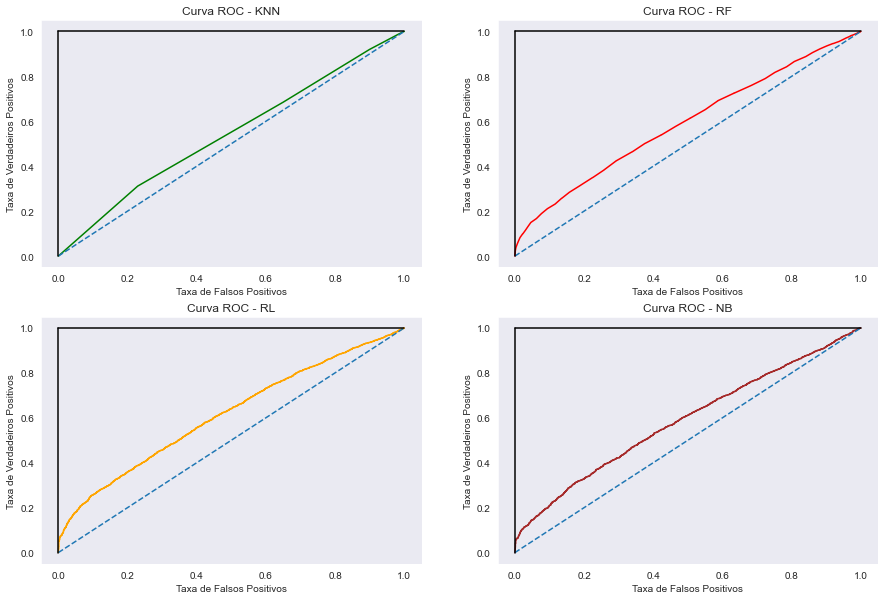

In [90]:
# Plotando as 4 curvas
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Curva ROC - KNN')
ax1.plot(false_positive_rate1, true_positive_rate1,c='green')
ax1.plot([0, 1], ls="--")
ax1.plot([0, 0], [1, 0] , c="0"), ax1.plot([1, 1] , c="0")
ax1.set_ylabel('Taxa de Verdadeiros Positivos')
ax1.set_xlabel('Taxa de Falsos Positivos')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Curva ROC - RF')
ax2.plot(false_positive_rate2, true_positive_rate2, c='red')
ax2.plot([0, 1], ls="--")
ax2.plot([0, 0], [1, 0] , c="0"), ax2.plot([1, 1] , c="0")
ax2.set_ylabel('Taxa de Verdadeiros Positivos')
ax2.set_xlabel('Taxa de Falsos Positivos')

ax3 = fig.add_subplot(2,2,3)
ax3.set_title('Curva ROC - RL')
ax3.plot(false_positive_rate3, true_positive_rate3,c='orange')
ax3.plot([0, 1], ls="--")
ax3.plot([0, 0], [1, 0] , c="0"), ax3.plot([1, 1] , c="0")
ax3.set_ylabel('Taxa de Verdadeiros Positivos')
ax3.set_xlabel('Taxa de Falsos Positivos')

ax4 = fig.add_subplot(2,2,4)
ax4.set_title('Curva ROC - NB')
ax4.plot(false_positive_rate4, true_positive_rate4,c='brown')
ax4.plot([0, 1], ls="--")
ax4.plot([0, 0], [1, 0] , c="0"), ax4.plot([1, 1] , c="0")
ax4.set_ylabel('Taxa de Verdadeiros Positivos')
ax4.set_xlabel('Taxa de Falsos Positivos')

Obs: Modelos com curva ROC mais próximos dos eixos em destaque, ou seja, mais proximos do coanto superior direito do plano cartesiano, são considerados melhores já que exibem uma maior taxa de Verdadeiros Positivos para um mesmo nível de falsos positivos.

Iremos concatenar em um dataframe o desempenho médio e o desvio padrão para cada classificador

In [91]:
# Criando listas com as métricas de interesse
scores_forest = pd.Series([acc_forest, acc_std_forest, f1_forest, f1_std_forest, aupcr_forest, aupcr_std_forest], name = 'Random Forest', dtype=float)
scores_reglog = pd.Series([acc_logistica, acc_std_logistica, f1_logistica, f1_std_logistica, aupcr_logistica, aupcr_std_logistica], name = 'Regressão Logística', dtype=float)
scores_knn = pd.Series([acc_knn, acc_std_knn, f1_knn, f1_std_knn, aupcr_knn, aupcr_std_knn], name = 'Knn', dtype=float)
scores_naive = pd.Series([acc_nb, acc_std_nb, f1_nb, f1_std_nb, aupcr_nb, aupcr_std_nb], name = 'Naive Bayes', dtype=float)
metricas = [scores_forest, scores_reglog, scores_knn, scores_naive]

# Concatenando resultados
resumo_metricas = pd.concat(metricas, axis=1)
resumo_metricas.rename(index={0 :'Média Acurácia',1:'DesvPad Acurácia',2:'Média F1score',3:'DesvPad F1score',4:'Média AUPRC',5:'DesvPad AUPRC'}, inplace=True)
resumo_metricas.T

,Média Acurácia,DesvPad Acurácia,Média F1score,DesvPad F1score,Média AUPRC,DesvPad AUPRC
Random Forest,0.778,0.000,0.689,0.001,0.783,0.000
Regressão Logística,0.509,0.001,0.546,0.002,0.812,0.002
Knn,0.739,0.002,0.692,0.002,0.784,0.001
Naive Bayes,0.742,0.044,0.687,0.008,0.786,0.004


### Lidando com o desbalanceamento no Target: oversampling e undersampling

- Nosso objetivo aqui é aplicar o oversampling com `smote()` que adiciona exemplos da classe minoritária nos dados de treino

- Depois aplicar o undersampling, ou seja, retirar exemplos da classe majoritária

- Por fim usar o `smoteenn` que combina a duas estratégias

- Estas estratégias conseguem melhorar a performance do modelo?

- Iremos utilizar o modelo Regressão Logística, pois ela desempenhou melhor pelo critério do  ``AUPRC`` e `AUC`, mesmo levando em consideração que os modelos concorrentes tenham um F1score maior . A decisão de priorizar o AUPCR parte da recomendação de utilziar esta métrica caso estejamos mais preocupados com a existência dos Falsos Positivos. Como  o negócio é baseado no "lead model", fazer cobranças indevidas (quando o modelo prevê que haverá lead, quando na verdade não existirá) deveria ser evitado para maiores problemas de relacionamento com o cliente. Além disto, esta métrica é independente do limiar (treshold) escolhido para definir a classe prevista, e ela nos computa a média ponderada da diferença entre precisão e recall. Quanto mais proximo de 1 (100%), melhor é o modelo.

1º estratégia: oversampling com `smote()`

In [92]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# verificando distribuição das classes nos dados originais
print("Distribuição das classes antes do método: ", Counter(y_treino))
over = SMOTE(sampling_strategy=0.5,random_state=0)

# Aplicando transformação nos dados de treino
X_over, y_over = over.fit_resample(X_treino,y_treino)

# verificando distribuição das classes nos dados pós-resampling
print("Distribuição das classes depois do método: ", Counter(y_over))

Distribuição das classes antes do método:  Counter({1: 22687, 0: 6322})
Distribuição das classes depois do método:  Counter({1: 22687, 0: 11343})


Agora iremos retreinar nosso Modelo Reg. Lostística com os dados usado o Resampling do SMOTE. 

Ps: As etapas são idênticas as realizadas na primeira versão do modelo, exceto pelos dados de treino X_over e y_over

In [93]:
# Lista de features categoricas
cols_categorica = [coluna for coluna in X_over.columns if X_over[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_over.columns if X_over[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado, mas instacioamos aqui a normalização dos dados também
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 2º modelo de Classificação
modelo_RL = LogisticRegression(random_state=0,penalty='l2', class_weight='balanced')

# Criando pipeline (transformadores + modelo)
pipeline_RL = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_RL)
                             ])

In [94]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_acuracias = []
lista_f1_scores = []
lista_aupcr_scores = []

for train_index, val_index in separador.split(X_over, y_over):
    X_treino_over, X_teste_over = X_over.iloc[train_index, :], X_over.iloc[val_index, :]
    y_treino_over, y_teste_over = y_over.iloc[train_index], y_over.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_RL.fit(X_treino_over, y_treino_over)
      previsao = pipeline_RL.predict(X_teste_over)
      
      # Calculando métricas para cada rodada
      acc = accuracy_score(y_teste_over, previsao)
      lista_acuracias.append(acc)

      _f1_score = f1_score(y_teste_over, previsao, average='weighted')
      lista_f1_scores.append(_f1_score)

      aupcr_score = average_precision_score(y_teste_over, previsao)
      lista_aupcr_scores.append(aupcr_score)
      
print("Treinamento Concluído")

Treinamento Concluído


In [95]:
# Calculando média e desvio padrão de acurácia das execuções
acc, acc_std = np.array(lista_acuracias).mean(), \
  np.array(lista_acuracias).std()
print(f'A acurácia média entre as execuções foi de {round(acc*100,2)}% com desvio padrão de {round(acc_std,4)}')

 #Calculando média e desvio padrão de f1score das execuções
f1, f1_std = np.array(lista_f1_scores).mean(),\
 np.array(lista_f1_scores).std()
print(f'O F1score médio entre as execuções foi de {round(f1*100,2)}% com desvio padrão de {round(f1_std,4)}')

# Calculando média e desvio padrão de AUPRC das execuções
aupcr, aupcr_std = np.array(lista_aupcr_scores).mean(),\
 np.array(lista_aupcr_scores).std()
print(f'O AUPRC entre as execuções foi de {round(aupcr*100,2)}% com desvio padrão de {round(aupcr_std,4)}')

A acurácia média entre as execuções foi de 57.23% com desvio padrão de 0.0024
O F1score médio entre as execuções foi de 58.19% com desvio padrão de 0.0026
O AUPRC entre as execuções foi de 72.38% com desvio padrão de 0.001


A aplicação do ``smote()`` nos reporta resultados melhores no `F1score` (0.546 versus 0.581), porém na métrica de referência do ``AUPRC`` (0.812 versus 0.723) foi relativamente prejudicada.

2 º Estratégia: undersampling com o `RandomUnderSampler()`

In [96]:
# verificando distribuição das classes nos dados originais
print("Distribuição das classes antes do método: ", Counter(y_treino))
under = RandomUnderSampler(sampling_strategy=0.5,random_state=0)

# Aplicando transformação nos dados de treino
X_under, y_under = under.fit_resample(X_treino,y_treino)

# verificando distribuição das classes nos dados pós-resampling
print("Distribuição das classes depois do método: ", Counter(y_under))

Distribuição das classes antes do método:  Counter({1: 22687, 0: 6322})
Distribuição das classes depois do método:  Counter({1: 12644, 0: 6322})


Agora iremos retreinar nosso Modelo KNN com os dados usado o Resampling do RandomUnderSampler. 

Ps: As etapas são idênticas as realizdas na primeira versão do modelo, exceto pelos dados de treino X_under e y_under

In [97]:
# Lista de features categoricas
cols_categorica = [coluna for coluna in X_under.columns if X_under[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_under.columns if X_under[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado, mas instacioamos aqui a normalização dos dados também
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 2º modelo de Classificação
modelo_RL = LogisticRegression(random_state=0,penalty='l2', class_weight='balanced')

# Criando pipeline (transformadores + modelo)
pipeline_RL = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_RL)
                             ])

In [98]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_acuracias = []
lista_f1_scores = []
lista_aupcr_scores = []

for train_index, val_index in separador.split(X_under, y_under):
    X_treino_under, X_teste_under = X_under.iloc[train_index, :], X_under.iloc[val_index, :]
    y_treino_under, y_teste_under = y_under.iloc[train_index], y_under.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_RL.fit(X_treino_under, y_treino_under)
      previsao = pipeline_RL.predict(X_teste_under)
      
      # Calculando métricas para cada rodada
      acc = accuracy_score(y_teste_under, previsao)
      lista_acuracias.append(acc)

      _f1_score = f1_score(y_teste_under, previsao, average='weighted')
      lista_f1_scores.append(_f1_score)

      aupcr_score = average_precision_score(y_teste_under, previsao)
      lista_aupcr_scores.append(aupcr_score)
      
print("Treinamento Concluído")

Treinamento Concluído


In [99]:
# Calculando média e desvio padrão de acurácia das execuções
acc, acc_std = np.array(lista_acuracias).mean(), \
  np.array(lista_acuracias).std()
print(f'A acurácia média entre as execuções foi de {round(acc*100,2)}% com desvio padrão de {round(acc_std,4)}')

 #Calculando média e desvio padrão de f1score das execuções
f1, f1_std = np.array(lista_f1_scores).mean(),\
 np.array(lista_f1_scores).std()
print(f'O F1score médio entre as execuções foi de {round(f1*100,2)}% com desvio padrão de {round(f1_std,4)}')

# Calculando média e desvio padrão de AUPRC das execuções
aupcr, aupcr_std = np.array(lista_aupcr_scores).mean(),\
 np.array(lista_aupcr_scores).std()
print(f'O AUPRC entre as execuções foi de {round(aupcr*100,2)}% com desvio padrão de {round(aupcr_std,4)}')

A acurácia média entre as execuções foi de 53.67% com desvio padrão de 0.0061
O F1score médio entre as execuções foi de 54.48% com desvio padrão de 0.0062
O AUPRC entre as execuções foi de 70.68% com desvio padrão de 0.0034


Na estratégia de remover exemplos da classe majoritária tivemos desempenho pior em ambas as métricas aqui comparadas. 

3º estratégia: combinar ambas reamostragens com o método `SMOOTENN`

In [100]:
# verificando distribuição das classes nos dados originais
print("Distribuição das classes antes do método: ", Counter(y_treino))

smotenn = SMOTEENN(sampling_strategy=0.5,random_state=0)

# Aplicando transformação nos dados de treino
X_smotenn, y_smotenn = smotenn.fit_resample(X_treino,y_treino)

# verificando distribuição das classes nos dados pós-resampling
print("Distribuição das classes depois do método: ", Counter(y_smotenn))

Distribuição das classes antes do método:  Counter({1: 22687, 0: 6322})
Distribuição das classes depois do método:  Counter({1: 9920, 0: 2583})


Agora iremos retreinar nosso Modelo Reg. Logística com os dados usado o ``SMOTEENN``. 

Ps: As etapas são idênticas as realizdas na primeira versão do modelo, exceto pelos dados de treino X_smotenn e y_smotenn

In [101]:
# Lista de features categoricas
cols_categorica = [coluna for coluna in X_smotenn.columns if X_smotenn[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_smotenn.columns if X_smotenn[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado, mas instacioamos aqui a normalização dos dados também
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 2º modelo de Classificação
modelo_RL = LogisticRegression(random_state=0,penalty='l2', class_weight='balanced')

# Criando pipeline (transformadores + modelo)
pipeline_RL = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_RL)
                             ])

In [102]:
execucoes = 5
lista_acuracias = []
lista_f1_scores = []
lista_aupcr_scores = []

for train_index, val_index in separador.split(X_smotenn, y_smotenn):
    X_treino_smotenn, X_teste_smotenn = X_smotenn.iloc[train_index, :], X_smotenn.iloc[val_index, :]
    y_treino_smotenn, y_teste_smoteen = y_smotenn.iloc[train_index], y_smotenn.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_RL.fit(X_treino_smotenn, y_treino_smotenn)
      previsao = pipeline_RL.predict(X_teste_smotenn)
      
      # Calculando métricas para cada rodada
      acc = accuracy_score(y_teste_smoteen, previsao)
      lista_acuracias.append(acc)

      _f1_score = f1_score(y_teste_smoteen, previsao, average='weighted')
      lista_f1_scores.append(_f1_score)

      aupcr_score = average_precision_score(y_teste_smoteen, previsao)
      lista_aupcr_scores.append(aupcr_score)
      
print("Treinamento Concluído")

Treinamento Concluído


In [103]:
# Calculando média e desvio padrão de acurácia das execuções
acc, acc_std = np.array(lista_acuracias).mean(), \
  np.array(lista_acuracias).std()
print(f'A acurácia média entre as execuções foi de {round(acc*100,2)}% com desvio padrão de {round(acc_std,4)}')

 #Calculando média e desvio padrão de f1score das execuções
f1, f1_std = np.array(lista_f1_scores).mean(),\
 np.array(lista_f1_scores).std()
print(f'O F1score médio entre as execuções foi de {round(f1*100,2)}% com desvio padrão de {round(f1_std,4)}')

# Calculando média e desvio padrão de AUPRC das execuções
aupcr, aupcr_std = np.array(lista_aupcr_scores).mean(),\
 np.array(lista_aupcr_scores).std()
print(f'O AUPRC entre as execuções foi de {round(aupcr*100,2)}% com desvio padrão de {round(aupcr_std,4)}')

A acurácia média entre as execuções foi de 58.34% com desvio padrão de 0.0036
O F1score médio entre as execuções foi de 62.15% com desvio padrão de 0.0033
O AUPRC entre as execuções foi de 85.05% com desvio padrão de 0.0029


In [104]:
# Relembrando as métricas do modelo Reg. Logística original
print(resumo_metricas['Regressão Logística'])

Média Acurácia     0.509
DesvPad Acurácia   0.001
Média F1score      0.546
DesvPad F1score    0.002
Média AUPRC        0.812
DesvPad AUPRC      0.002
Name: Regressão Logística, dtype: float64


O `smoteenn` reporta o melhor upgrade no nosso modelo, demostrando significativa melhora nos resultados do `f1score` e `AUPRC`. Além disto, o desvio padrão entre as métricas apuradas para cada modelo executado dentro da cross-validation manteve-se relativamente sob controle, o que nos indica certa consistência dos resultados entre os 20 modelos executados. 

Agora que selecionamos o Modeo KNN com resample pelo método Smoteenn, podemos verificar melhor seus resultados com a sua matriz de confusão e o o ``classification_report()`` do sklearn



In [105]:
# Classification Report

print(classification_report(y_teste_smoteen, previsao))

              precision    recall  f1-score   support

           0       0.30      0.76      0.43       645
           1       0.89      0.54      0.67      2480

    accuracy                           0.58      3125
   macro avg       0.60      0.65      0.55      3125
weighted avg       0.77      0.58      0.62      3125



- Comparando com o modelo KNN original podemos observar que houve significativa melhora em todas as métricas quando nosso modelo tenta prever a classe 0, ou seja, quando ele informa que determinado anúncio não terá um lead. Neste caso os métodos de reamostragem foram adequados para atacar este problema.

- Podemos atestar isto também verificando a matriz de confusão deste modelo

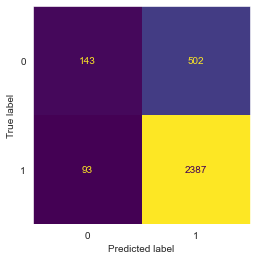

In [106]:
# Matriz de Confusão

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline_KNN, X_teste_smotenn, y_teste_smoteen, colorbar=False)

### Modelos de Regressão:

- Agora nosso objetivo é criar modelos que sejam capazes de prever a quantidade de leads que um determinado anúncio pode gerar. Para tal, iremos construir modelos concorrentes de regressão linear, random forest e rede neural simples. 

- Iremos utilizar os mesmos dados tratados pelas etapas de feature selection e engineering realizadas para o modelo anterior, pois nosso objetivo apesar de ser diferente (prever quantidade de leads e não se ele existirá), há correlação direta entre quantidade de leads e a existência dos mesmos, pois quantidade_leads > 0 = has_leads = 1 e vice-versa

Para redefinir nosso target iremos novamente processar os dados para aplicar as transformações nas features de alta cardinaldiade, mas preservando nosso target y = leads

In [107]:
# Redefinindo o target para a variável leads e retirando variável has_leads do conjuto de features

# Separação dos dados para o encoding (20%  dataset)
X_encode = dados.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("leads")

# Separação para treinar o encoder (75% dataset)
X_pretrain = dados.drop(X_encode.index)
y_regressao = X_pretrain.pop("leads")

# Selecionando features a serem transformadas e configurando a suaviação (m)
encoder = MEstimateEncoder(cols=['cidade','combustivel','cod_marca_veiculo','cod_modelo_veiculo','uf'], m=5)

# Realizando fit
encoder.fit(X_encode,y_encode)

# Aplicando transformação nos dados de treino
X_regressao = encoder.transform(X_pretrain, y)

In [108]:
# Retirando do conjunto de features a variável `has_leads`

X_regressao.drop(['has_leads'],axis=1,inplace=True)

OBSERVAÇÃO: 

- As features selecionadas pelo método de Mutual Information são as mesmas aplicadas aqui e não precisamos repetir este passo. Mas para termos o mesmo conjunto de features usadas no modelo de classificação, iremos processar novamente a criação de features pelo smoothing e pelo Kmeans. Estas estapas são rigorosamente iguais as anteriores, mas agora aplicadas ao nosso novo target.

In [109]:
# Removendo colunas que não passaram pelo critério anterior do método de Mutual Information

X_regressao.drop(['cambio', 'ano_modelo','bancocouro','flg_garantia_fabrica','alarme','arquente',\
'flg_unico_dono','sensorchuva','desembtras','rodasliga','flg_blindado','portas','flg_adaptado_pcd',\
'airbag','sensorestacion','vidroseletr','travaeletr','abs','arcondic'],axis=1,inplace=True)

In [110]:
# Recriando clusters de anúncios similares iguais ao modelo de classificação
features = X_regressao.columns

# Aplicando padronização: kmeans é sensivel as escalas
X_scaled = X_regressao.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

X_scaled.fillna(0,axis=0,inplace=True) # a transformação cria zeros e o phyton reconhece como NaN

# Realizando Fit
kmeans = KMeans(n_clusters=5, random_state=0)
X_regressao["Cluster"] = kmeans.fit_predict(X_scaled)
X_regressao["Cluster"].head()

1    1
2    3
3    1
5    3
6    1
Name: Cluster, dtype: int32

In [111]:
# Agora temos o mesmo conjunto de features usada no treinamento dos modelos de classificação para nossos modelos regressivos
X_regressao.columns

Index(['prioridade', 'views', 'cliques_telefone*', 'cod_marca_veiculo',
       'cod_modelo_veiculo', 'vlr_anuncio', 'qtd_fotos', 'km_veiculo',
       'vlr_mercado', 'flg_licenciado', 'flg_ipva_pago',
       'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_aceita_troca', 'combustivel',
       'uf', 'cidade', 'Cluster'],
      dtype='object')

1º MODELO: Regressão Linear

OBSERVAÇÃO:

- Como não estamos mais lidado com um modelo de classificação e nosso target é numérico, iremos utilizar a validação cruzada do tipo ``Kfold()`` e não mais uma validação estratificada, já que não há desbalanceamento de classes neste caso

In [112]:
# Aplicando split (valerá para todos os modelos regressivos)
from sklearn.model_selection import KFold

separador_regressao = KFold(n_splits=4, shuffle=True, random_state=0)

for train_index, val_index in separador_regressao.split(X_regressao, y_regressao):
    X_treino_regressao, X_teste_regressao = X_regressao.iloc[train_index, :], X_regressao.iloc[val_index, :]
    y_treino_regressao, y_teste_regressao = y_regressao.iloc[train_index], y_regressao.iloc[val_index]

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado + scaler (normalização)
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())
])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 1º modelo de Regressão
modelo_RLIN = LinearRegression()

# Criando pipeline (transformadores + modelo)
pipeline_RLIN = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_RLIN)
                             ])

In [114]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_mae = []
lista_mse = []
lista_rmse = []

for train_index, val_index in separador_regressao.split(X_regressao, y_regressao):
    X_treino_regressao, X_teste_regressao = X_regressao.iloc[train_index, :], X_regressao.iloc[val_index, :]
    y_treino_regressao, y_teste_regressao = y_regressao.iloc[train_index], y_regressao.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_RLIN.fit(X_treino_regressao, y_treino_regressao)
      previsao = pipeline_RLIN.predict(X_teste_regressao)
      
      # Calculando métricas para cada rodada
      mae = mean_absolute_error(y_teste_regressao, previsao)
      lista_mae.append(mae)

      mse = mean_squared_error(y_teste_regressao, previsao)
      lista_mse.append(mse)

      rmse = np.sqrt(mse)
      lista_rmse.append(rmse)
      
print("Treinamento Concluído")

Treinamento Concluído


In [115]:
# Calculando média e desvio padrão de MAE das execuções
mae_reglin, mae_std_reglin = np.array(lista_mae).mean(), \
  np.array(lista_mae).std()
print(f'O erro absoluto médio entre as execuções foi de {round(mae_reglin,2)} leads com desvio padrão de {round(mae_std_reglin,4)}')

 #Calculando média e desvio padrão de MSE das execuções
mse_reglin, mse_std_reglin = np.array(lista_mse).mean(),\
 np.array(lista_mse).std()
print(f'O erro quadrático médio entre as execuções foi de {round(mse_reglin,2)} leads com desvio padrão de {round(mse_std_reglin,4)}')

# Calculando média e desvio padrão de RMSE das execuções
rmse_reglin, rmse_std_reglin = np.array(lista_rmse).mean(),\
 np.array(lista_rmse).std()
print(f'A raiz do erro quadrático médio entre as execuções foi de {round(rmse_reglin,2)} leads com desvio padrão de {round(rmse_std_reglin,4)}')

O erro absoluto médio entre as execuções foi de 3.7 leads com desvio padrão de 0.0263
O erro quadrático médio entre as execuções foi de 48.23 leads com desvio padrão de 5.6617
A raiz do erro quadrático médio entre as execuções foi de 6.93 leads com desvio padrão de 0.4005


2º MODELO: Baseado em árvores para regressão (RandomForest)

In [116]:
from sklearn.ensemble import RandomForestRegressor

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado + scaler (normalização)
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())
])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 2º modelo de Regressão
modelo_REGFOREST = RandomForestRegressor(random_state=0, max_depth=100)

# Criando pipeline (transformadores + modelo)
pipeline_REGFOREST = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_REGFOREST)
                             ])

In [117]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_mae = []
lista_mse = []
lista_rmse = []

for train_index, val_index in separador_regressao.split(X_regressao, y_regressao):
    X_treino_regressao, X_teste_regressao = X_regressao.iloc[train_index, :], X_regressao.iloc[val_index, :]
    y_treino_regressao, y_teste_regressao = y_regressao.iloc[train_index], y_regressao.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_REGFOREST.fit(X_treino_regressao, y_treino_regressao)
      previsao = pipeline_REGFOREST.predict(X_teste_regressao)
      
      # Calculando métricas para cada rodada
      mae = mean_absolute_error(y_teste_regressao, previsao)
      lista_mae.append(mae)

      mse = mean_squared_error(y_teste_regressao, previsao)
      lista_mse.append(mse)

      rmse = np.sqrt(mse)
      lista_rmse.append(rmse)
      
print("Treinamento Concluído")

Treinamento Concluído


In [118]:
# Calculando média e desvio padrão de MAE das execuções
mae_forest, mae_std_forest = np.array(lista_mae).mean(), \
  np.array(lista_mae).std()
print(f'O erro absoluto médio entre as execuções foi de {round(mae_forest,2)} leads com desvio padrão de {round(mae_std_forest,4)}')

 #Calculando média e desvio padrão de MSE das execuções
mse_forest, mse_std_forest = np.array(lista_mse).mean(),\
 np.array(lista_mse).std()
print(f'O erro quadrático médio entre as execuções foi de {round(mse_forest,2)} leads com desvio padrão de {round(mse_std_forest,4)}')

# Calculando média e desvio padrão de RMSE das execuções
rmse_forest, rmse_std_forest = np.array(lista_rmse).mean(),\
 np.array(lista_rmse).std()
print(f'A raiz do erro quadrático médio entre as execuções foi de {round(rmse_forest,2)} leads com desvio padrão de {round(rmse_std_forest,4)}')

O erro absoluto médio entre as execuções foi de 3.03 leads com desvio padrão de 0.014
O erro quadrático médio entre as execuções foi de 43.04 leads com desvio padrão de 4.8984
A raiz do erro quadrático médio entre as execuções foi de 6.55 leads com desvio padrão de 0.3653


3º MODELO: MLPRegressor (Rede Neural)

In [119]:
from sklearn.neural_network import MLPRegressor

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado + scaler 
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())
])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 3º modelo de Regressão
modelo_MLP = MLPRegressor(random_state=0, max_iter = 500)

# Criando pipeline (transformadores + modelo)
pipeline_MLP = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_MLP)
                             ])

In [120]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_mae = []
lista_mse = []
lista_rmse = []

for train_index, val_index in separador_regressao.split(X_regressao, y_regressao):
    X_treino_regressao, X_teste_regressao = X_regressao.iloc[train_index, :], X_regressao.iloc[val_index, :]
    y_treino_regressao, y_teste_regressao = y_regressao.iloc[train_index], y_regressao.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_MLP.fit(X_treino_regressao, y_treino_regressao)
      previsao = pipeline_MLP.predict(X_teste_regressao)
      
      # Calculando métricas para cada rodada
      mae = mean_absolute_error(y_teste_regressao, previsao)
      lista_mae.append(mae)

      mse = mean_squared_error(y_teste_regressao, previsao)
      lista_mse.append(mse)

      rmse = np.sqrt(mse)
      lista_rmse.append(rmse)
      
print("Treinamento Concluído")

Treinamento Concluído


In [121]:
# Calculando média e desvio padrão de MAE das execuções
mae_mlp, mae_std_mlp = np.array(lista_mae).mean(), \
  np.array(lista_mae).std()
print(f'O erro absoluto médio entre as execuções foi de {round(mae_mlp,2)} leads com desvio padrão de {round(mae_std_mlp,4)}')

 #Calculando média e desvio padrão de MSE das execuções
mse_mlp, mse_std_mlp = np.array(lista_mse).mean(),\
 np.array(lista_mse).std()
print(f'O erro quadrático médio entre as execuções foi de {round(mse_mlp,2)} leads com desvio padrão de {round(mse_std_mlp,4)}')

# Calculando média e desvio padrão de RMSE das execuções
rmse_mlp, rmse_std_mlp = np.array(lista_rmse).mean(),\
 np.array(lista_rmse).std()
print(f'A raiz do erro quadrático médio entre as execuções foi de {round(rmse_mlp,2)} leads com desvio padrão de {round(rmse_std_mlp,4)}')

O erro absoluto médio entre as execuções foi de 3.1 leads com desvio padrão de 0.0245
O erro quadrático médio entre as execuções foi de 41.86 leads com desvio padrão de 4.3812
A raiz do erro quadrático médio entre as execuções foi de 6.46 leads com desvio padrão de 0.3328


4º MODELO: ElasticNet.

- O objetivo é treinar um modelo com o método ``ElasticNetCV()`` par achar o parâmero alfa ideal e retreinar um novo modelo ajustado pelo parâmetro em questão.

1º passo: treinar um modelo com o ``ElasticNetCV()``

In [122]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

# Lista de features categoricas
cols_categorica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype == "object"]

# Lista de features numéricas
cols_numerica = [coluna for coluna in X_treino_regressao.columns if X_treino_regressao[coluna].dtype in ['int64', 'float64']]

# Instanciando transformador numérico: tratamento de NaN's ja realizado + scaler 
transformador_numerico = Pipeline(steps=[('scaler', StandardScaler())
])

# Instanciando transformador categorico
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Definindo as transformações a serem realizadas
processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, cols_numerica),
        ('cat', transformador_categorico, cols_categorica)
    ])

# Selecionando o 4º modelo de Regressão
modelo_enetCV = ElasticNetCV(random_state=0, l1_ratio=0.5)

# Criando pipeline (transformadores + modelo)
pipeline_ELASTICV = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_enetCV)
                             ])

In [123]:
# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_mae = []
lista_mse = []
lista_rmse = []

for train_index, val_index in separador_regressao.split(X_regressao, y_regressao):
    X_treino_regressao, X_teste_regressao = X_regressao.iloc[train_index, :], X_regressao.iloc[val_index, :]
    y_treino_regressao, y_teste_regressao = y_regressao.iloc[train_index], y_regressao.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_ELASTICV.fit(X_treino_regressao, y_treino_regressao)
      previsao = pipeline_ELASTICV.predict(X_teste_regressao)
      
      # Calculando métricas para cada rodada
      mae = mean_absolute_error(y_teste_regressao, previsao)
      lista_mae.append(mae)

      mse = mean_squared_error(y_teste_regressao, previsao)
      lista_mse.append(mse)

      rmse = np.sqrt(mse)
      lista_rmse.append(rmse)
      
print("Treinamento Concluído")

Treinamento Concluído


In [124]:
# Identificando o parâmetro alfa para tuning do modelo

modelo_enetCV.alpha_

0.01802349931352266

2º passo: Realizar retreino do modelo com o parâmetro alfa

In [125]:
modelo_enetCV_ajustado = ElasticNet(random_state=0, alpha=modelo_enetCV.alpha_)

# Passando para o pipeline o modelo ajustado
pipeline_ELASTICV_ajust = Pipeline(steps=[('preprocessor', processador),
                              ('model', modelo_enetCV_ajustado)
                             ])

# Loop para rodar 5 execuções em cada folder criado no split (n_fold = 4)
execucoes = 5
lista_mae = []
lista_mse = []
lista_rmse = []

for train_index, val_index in separador_regressao.split(X_regressao, y_regressao):
    X_treino_regressao, X_teste_regressao = X_regressao.iloc[train_index, :], X_regressao.iloc[val_index, :]
    y_treino_regressao, y_teste_regressao = y_regressao.iloc[train_index], y_regressao.iloc[val_index]
    for run in range(execucoes):
            
      # Treinando o modelo usando o pipeline configurado previamente
      pipeline_ELASTICV_ajust.fit(X_treino_regressao, y_treino_regressao)
      previsao = pipeline_ELASTICV_ajust.predict(X_teste_regressao)
      
      # Calculando métricas para cada rodada
      mae = mean_absolute_error(y_teste_regressao, previsao)
      lista_mae.append(mae)

      mse = mean_squared_error(y_teste_regressao, previsao)
      lista_mse.append(mse)

      rmse = np.sqrt(mse)
      lista_rmse.append(rmse)
      
print("Treinamento Concluído")

Treinamento Concluído


In [126]:
# Calculando média e desvio padrão de MAE das execuções
mae_elastic, mae_std_elastic = np.array(lista_mae).mean(), \
  np.array(lista_mae).std()
print(f'O erro absoluto médio entre as execuções foi de {round(mae_elastic,2)} leads com desvio padrão de {round(mae_std_elastic,4)}')

 #Calculando média e desvio padrão de MSE das execuções
mse_elastic, mse_std_elastic = np.array(lista_mse).mean(),\
 np.array(lista_mse).std()
print(f'O erro quadrático médio entre as execuções foi de {round(mse_elastic,2)} leads com desvio padrão de {round(mse_std_elastic,4)}')

# Calculando média e desvio padrão de RMSE das execuções
rmse_elastic, rmse_std_elastic = np.array(lista_rmse).mean(),\
 np.array(lista_rmse).std()
print(f'A raiz do erro quadrático médio entre as execuções foi de {round(rmse_elastic,2)} leads com desvio padrão de {round(rmse_std_elastic,4)}')

O erro absoluto médio entre as execuções foi de 3.69 leads com desvio padrão de 0.0253
O erro quadrático médio entre as execuções foi de 48.23 leads com desvio padrão de 5.7963
A raiz do erro quadrático médio entre as execuções foi de 6.93 leads com desvio padrão de 0.4097


Agora iremos resumir em um dataframe as métricas de cada modelo com suas respectivas médias e desvio-padrão

In [127]:
# Criando listas com as métricas de interesse
scores_reg_linear = pd.Series([mae_reglin, mae_std_reglin, mse_reglin, mse_std_reglin, rmse_reglin, rmse_std_reglin], name = 'Regressão Linear')
scores_forest = pd.Series([mae_forest, mae_std_forest, mse_forest, mse_std_forest, rmse_forest, rmse_std_forest],name = 'Random Forest')
scores_mlp = pd.Series([mae_mlp, mae_std_mlp, mse_mlp, mse_std_mlp, rmse_mlp, rmse_std_mlp],name = 'Mlp Regressor')
scores_elastic = pd.Series([mae_elastic, mae_std_elastic, mse_elastic, mse_std_elastic, rmse_elastic, rmse_std_elastic],name = 'Elastic Net')
metricas = [scores_reg_linear,scores_forest,scores_mlp,scores_elastic]

# Concatenando resultados
resumo_metricas = pd.concat(metricas, axis=1)
resumo_metricas.rename(index={0 :'Média MAE',1:'DesvPad MAE',2:'Média MSE',3:'DesvPad MSE',4:'Média RMSE',5:'DesvPad RMSE'}, inplace=True)
resumo_metricas.T

,Média MAE,DesvPad MAE,Média MSE,DesvPad MSE,Média RMSE,DesvPad RMSE
Regressão Linear,3.704,0.026,48.226,5.662,6.933,0.400
Random Forest,3.027,0.014,43.035,4.898,6.550,0.365
Mlp Regressor,3.096,0.025,41.863,4.381,6.462,0.333
Elastic Net,3.685,0.025,48.234,5.796,6.933,0.410


Verificando os Coeficientes dos Modelos Lineares: 

- Coeficientes positivos indicam uma relação diretamente proporcional entre a feature e nossa variável Leads, vice-versa.

- Como o coenficiente pode ser interpretado? Tomando como exemplo a feature de Valor de mercado, temos que o aumento em 1 R$ no valor de mercado do veículo está associado com uma redução (coeficiente negativo) de 0,23 leads por anúncio. Esta interpretação é similar para as features negativamente correlacionadas. No exemplo de cliques ao telefone, o modelo informa que o aumento em 1 clique no telefone está associado com um acréscimo (coeficiente positivo) de 9,2 Leads gerados por anúncio. 

In [128]:
print(list(zip(X_regressao.columns,np.around(modelo_RLIN.coef_,4))))

[('prioridade', 0.0826), ('views', 0.0769), ('cliques_telefone*', 8.969), ('cod_marca_veiculo', 0.2617), ('cod_modelo_veiculo', 0.0249), ('vlr_anuncio', -0.0773), ('qtd_fotos', -0.017), ('km_veiculo', -0.0979), ('vlr_mercado', -0.2764), ('flg_licenciado', 0.083), ('flg_ipva_pago', -0.0522), ('flg_todas_revisoes_concessionaria', -0.5108), ('flg_todas_revisoes_agenda_veiculo', 0.0006), ('flg_aceita_troca', 0.0635), ('combustivel', 0.9318)]


In [129]:
print(list(zip(X_regressao.columns,np.around(modelo_enetCV_ajustado.coef_,4))))

[('prioridade', 0.0637), ('views', 0.0611), ('cliques_telefone*', 8.8633), ('cod_marca_veiculo', 0.2518), ('cod_modelo_veiculo', 0.0257), ('vlr_anuncio', -0.0679), ('qtd_fotos', -0.0043), ('km_veiculo', -0.0827), ('vlr_mercado', -0.2574), ('flg_licenciado', 0.0765), ('flg_ipva_pago', -0.0366), ('flg_todas_revisoes_concessionaria', -0.4747), ('flg_todas_revisoes_agenda_veiculo', 0.0), ('flg_aceita_troca', 0.0684), ('combustivel', 0.9204)]


### Considerações finais sobre os regressores:

- O melhor modelo em termos de métricas é o ``MLPRegressor()``, pois apresenta o melhor desempenho pelo ``MSE`` e ``RMSE`` em comparação aos demais. Em geral, o erro médio computado pelo RMSE é de aproximadamente 6 leads. Isto indica que caso nosso modelo preveja que determinado anúncio irá gerar 10 Leads, possuímos esta margem de erro de 6 Leads, levando a um intervalo entre 4 e 16 leads. Os melhores resultados entre os modelos foram encontrados com dados padronizados ao invés de dados normalizados, já que reportamos apenas os resultados daquela 1º estratégia. 

- No entanto este desempenho não é significativamente diferente dos modelos concorrentes. Com isto, argumentamos que este modelo possui maior carga computacional e seu tempo de treinamento não é desprezível, levando em consideração que estamos tratando com uma base relativamente pequena. 

- Portanto, caso a eficiência computacional seja prioridade no deploy do modelo, recomendamos a utilização dos modelos lineares (Regressão Linear ou ElasticNet), pois seu tempo de execução e sua carga computacional é relativamente menor. 